In [1]:
import pandas as pd
import numpy as np
import bambi as bmb
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import transforms
from itertools import product
import pyfixest as pf
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix
import seaborn as sns
import networkx as nx
from pyfixest.did.estimation import did2s, lpdid
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

np.random.seed(100)


::: {.callout-note}
## Summary 
_Two Way Fixed Effects (TWFE) regression models are often used in Differences-in-Differences designs to estimate treatment effects while accounting for variation due to group effects in two dimensions. In recent years econometricians have discovered a number of issues with the TWFE estimator and clever diagnostics and corrections have been suggested. Woolridge recently has shown that TWFE can be seen as a species of Mundlak regression offering further insight into the problem. We unpack what this means and what it suggests for model development in causal inference._
:::

# Architectures and Free Parameters

> “There are no rules of architecture for a castle in the clouds.” - G.K. Chesterton

Free choice is not whimsy or wanton action. Choice is free when taken within the confines of tolerable bounds. In statistical modelling we seek to discover what is plausibly realised within such bounds. We learn from the past to discern the shape of the processes which determine the future. Different models yield different insights into those structures which govern our trajectories. Which parameters are "free", and which are decisively characterised? Which realities are contestable and which non-negotiable? In this post we will dive into the way in which different inferential methodologies yield different insights into how group-level confounding constrains the realisations of our parameter space and shapes the architecture of causal inference.

<img src="free_choice.png" width="500" height="300" />

Difference in Differences estimation is core a topic in contemporary social science and causal inference. It is a compelling methodology for licensing inferential statements about policy effects, but it is not a panacea. The method makes substantive assumptions about the treatment regime and the trends in the process before the treatment is introduced, but it also requires that the data is rich enough to mandate the intended interpretation of a heavily parameterised estimation model. The two-way fixed effects models attempt to tightly estimate the treatment effect by controlling for all sources of variation in our treatment due to group level factors in the DiD designs. These controls isolate the variation due to actual treatment by pinning down the effects of interactions between treatment-units and time.  We will see how these models and their intended interpretation come apart quickly in the face of staggered treatment roll-outs. We will also show how to fix these issues by enriching our regression specification. 

### Structure of the Presentation
In this post we will structure the discussion as follows: 

- Estimation Strategies and Group Effects
    - We go through a paired down parameter recovery examples of group-confounding and a range of estimation strategies aiming to account for group effect bias.
- Nested Groups, Hierarchies and Fixed Effects
    - We work through a real example of three-level group nesting; pupils in classes, in schools. Where we need to make decisions about the estimation strategy. 
- Two Way Fixed Effects and Temporal Confounding
    - We branch off into examining an analogous case of confouning addressed in DiD designs. We show how TWFE works and how to specify these regression designs using Fixed Effects and Mundlak devices.
- Issues with TWFE and Richly Parameterised Linear Models
    - We examine the problems arising for the TWFE estimator in the case of staggered roll-outs. We also see how to address the issue with Mundlak devices, and reflect on what we've seen.
    

## Estimation Strategies and Group Effects

First consider an estimation example due to Richard McElreath's [lecture series](https://www.youtube.com/playlist?list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus) where we examine the various parameter recovery options available in the case of group level confounding. We want to move through these parameterisations to highlight the usefulness of Mundlak regressions. The source of these models is a paper Mundlak's 1978 paper _"On the pooling of time series and cross section data"_ in which he shows a method for adjusting for group-levels which proves to be a viable alternative to richly specified fixed effects model as we'll see. 

First define a data generating process determined by group level effects:


In [2]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

N_groups = 30
N_id = 3000
a0 = -2
bXY = 1
bZY = -0.5
g = np.random.choice(range(N_groups), size=N_id, replace=True)
Ug = np.random.normal(1.5, size=N_groups)

X = np.random.normal(Ug[g], size=N_id)
Z = np.random.normal(size=N_groups)

s = a0 + bXY*X + Ug[g] + bZY*Z[g]
p = inv_logit(s)
Y = np.random.binomial(n=1, p=p)


sim_df = pd.DataFrame({'Y': Y, 'p': p, 's': s, 'g': g, 'X': X, 'Z': Z[g]})
sim_df.head()

Y         p         s   g         X         Z
0  1  0.943243  2.810542   8  1.384072 -1.818302
1  0  0.593872  0.379996  24  1.047128 -0.242817
2  1  0.874945  1.945406   3  2.340418 -0.650122
3  0  0.317089 -0.767181   7  0.550504  0.795680
4  1  0.699030  0.842684  23  1.183011 -0.111692

This data generating process is characterised by the bernoulli outcome with group level confounds. If we model this relationship the confounding effects will bias naive parameter estimates on the covariates $X$, $Z$. We can imagine this is a class room setting with group-confounding due to teacher effects. In a DAG we see a picture something like this: 


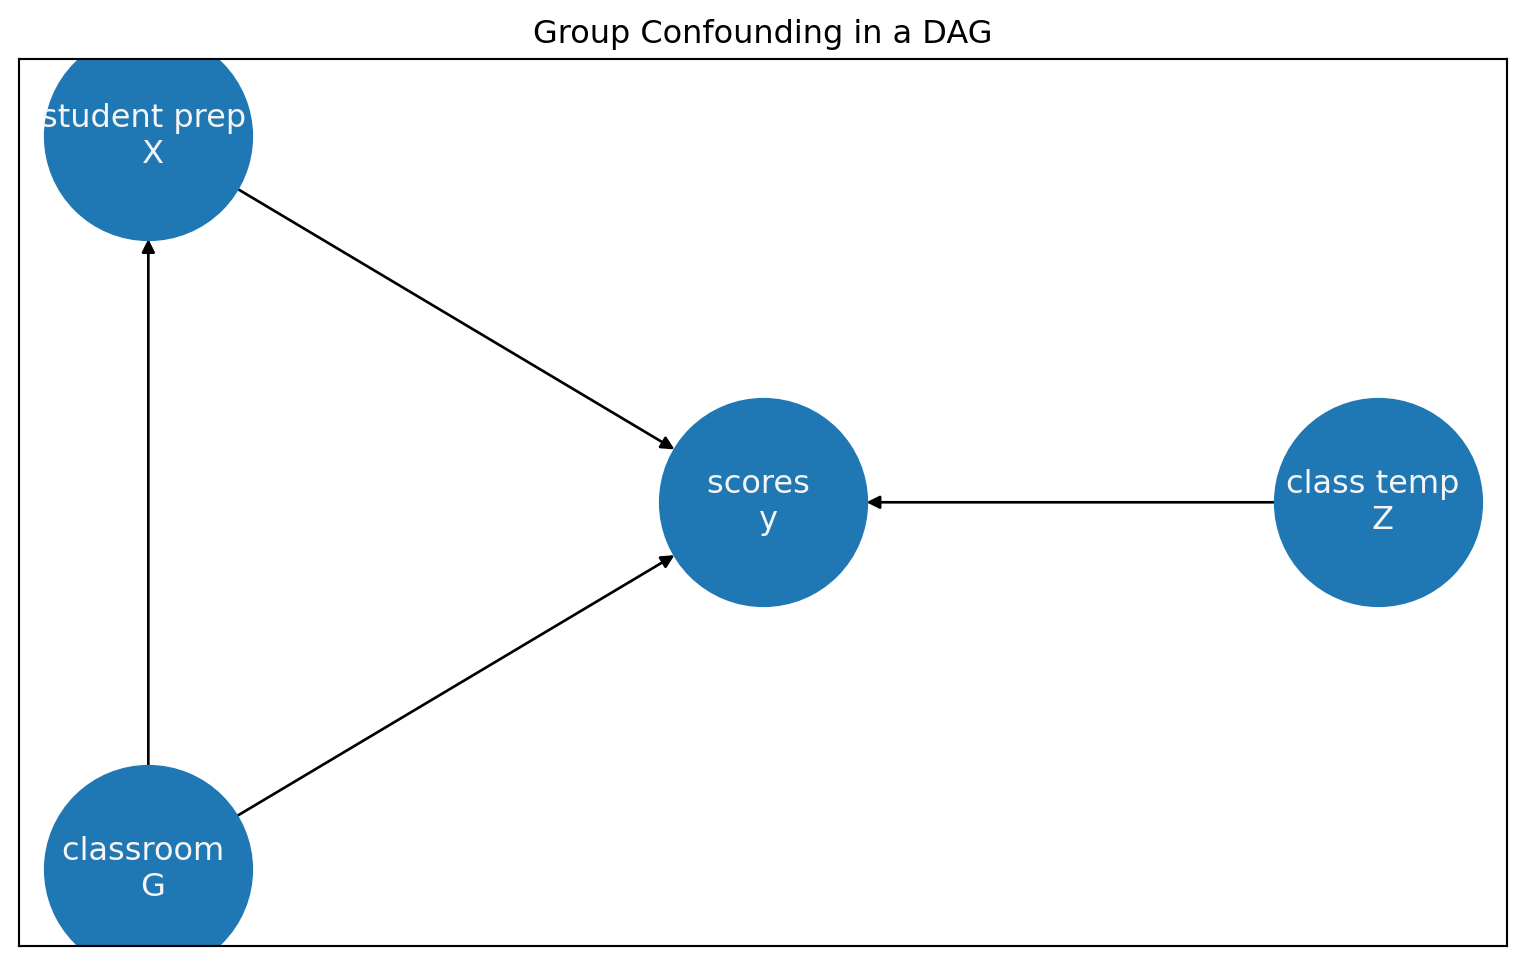

In [3]:
graph = nx.DiGraph()
graph.add_edges_from([("classroom \n G", "scores \n y"), ("classroom \n G", "student prep \n X"), ("student prep \n X", "scores \n y"), ("class temp \n Z", "scores \n y")])
fig, ax = plt.subplots(figsize=(10,6))
nx.draw_networkx(graph, arrows=True, ax=ax, 
node_size = 6000, font_color="whitesmoke",pos={'classroom \n G': [0, 0], 'scores \n y': [0.5, 1], 'student prep \n X': [0, 2], 
'class temp \n Z': [1, 1]})
ax.set_title("Group Confounding in a DAG", fontsize=12);

We can plot the data here to visualise the shares of the binary outcomes. 


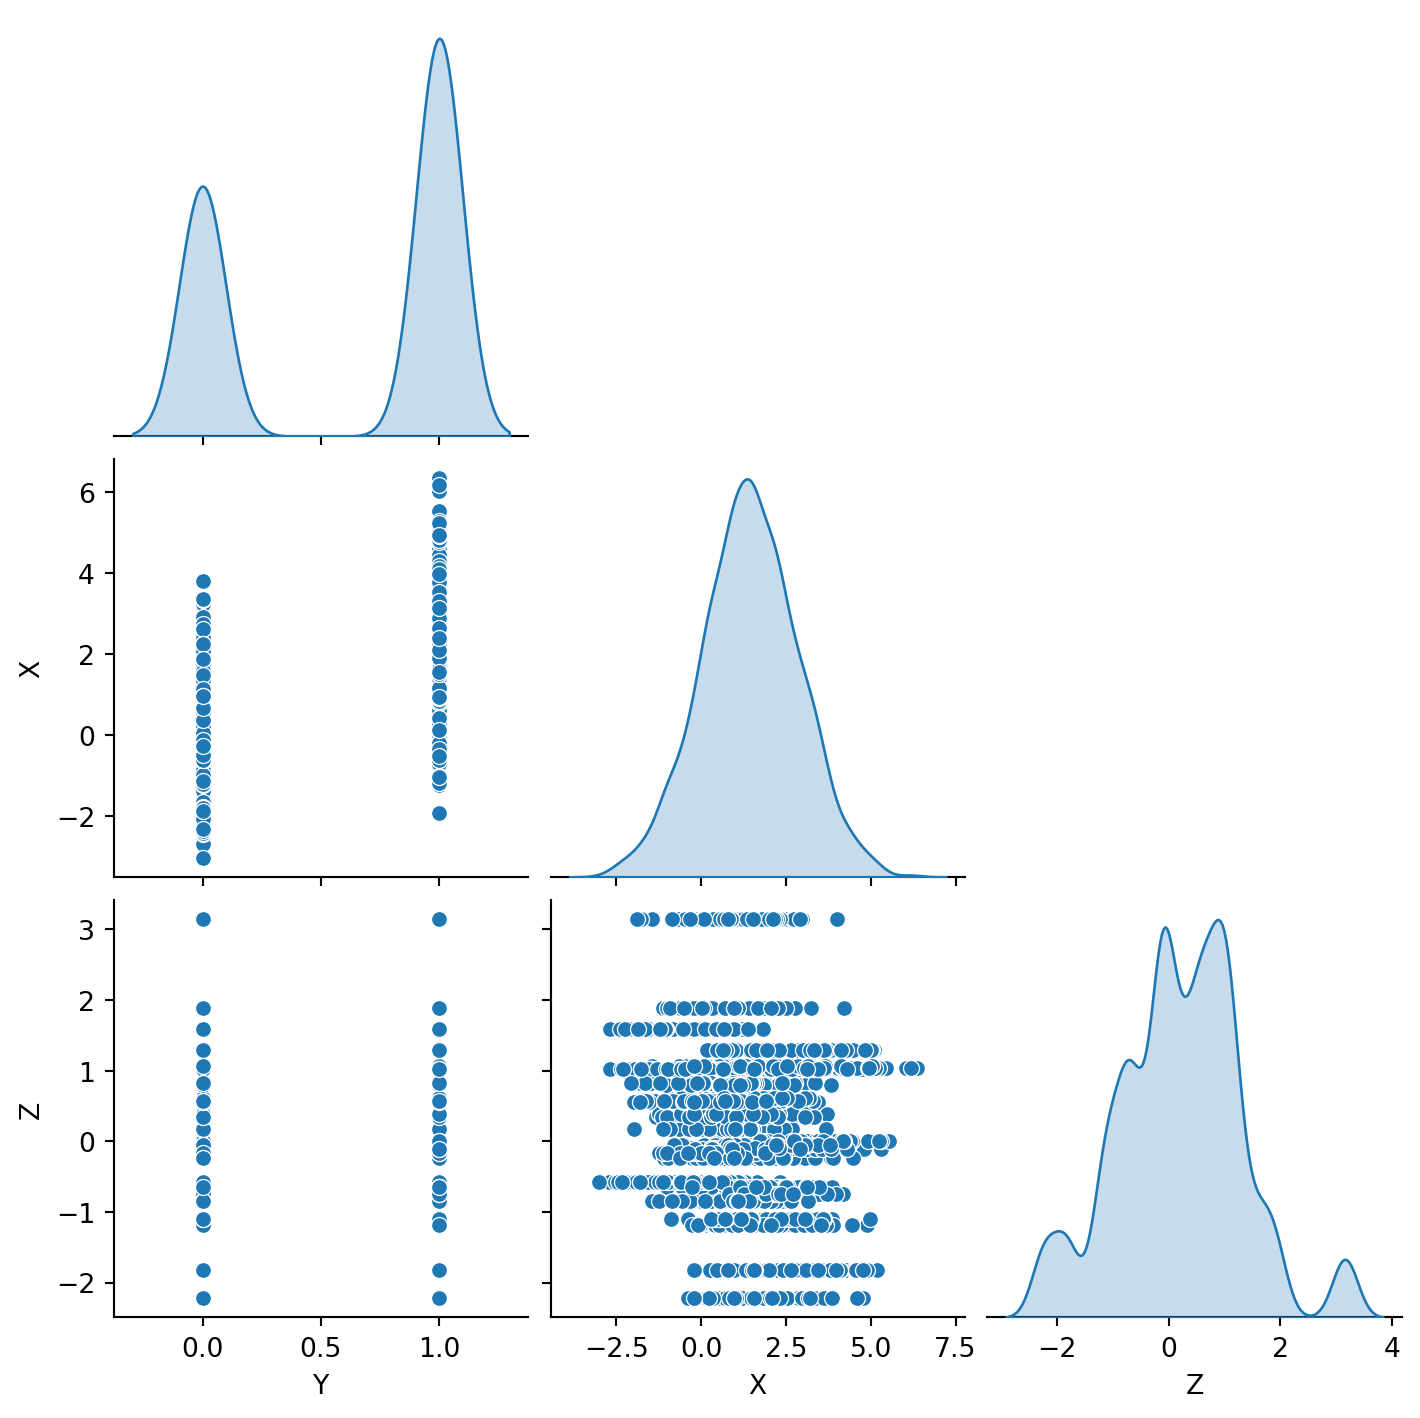

In [4]:
g = sns.pairplot(sim_df[['Y', 'X', 'Z']], diag_kind="kde", corner=True)
g;

We will see different estimation results as we explore different ways of parameterising the relationships, and the trade-offs for model specifications will become clearer.

::: {.callout-warning title="Terminology Warning"}
There is a huge degree of confusion over the meaning of the terms "Fixed Effects" and "Random Effects". Within this blog post when we refer to __fixed effects__ we will mean the population level parameters. 
 $$\beta X$$ 
 
In contrast we will refer to group-level parameters $\beta_{g}$

 $$\Big(\underbrace{\beta}_{pop} + \underbrace{\beta_{g}}_{group}\Big)X$$
 

which are incorporated into our model equation modifying population level parameters as __random effects.__ We will generally use Wilkinson notation to specify these choices. Random effects for modifying a population parameter `X` are denoted with a conditional bar over the variable `( X | group)` and fixed effects are specified by just including the variable in the equation i.e. `y ~ X + (Z | group)` where X has a fixed effect parameterisation and Z a random effects parameterisation. We can also create indicator variables for group membership using this syntax with `y ~ C(group) + X + Z` where under the hood we pivot the group category into a zero-one variables indicating group membership. This parameterisation means each indicator variable (one for each level of the grouping variable) will receive a fixed effects population parameter.   
:::

### Naive Model

We will use `Bambi` to specify the majority of these generalised linear models throughout this post. The formula syntax for `Bambi` enables us to specify generalised linear models with bernoulli outcomes. 


In [5]:
#| output: false
#| 
naive_model = bmb.Model(f"Y['>.5'] ~ X + Z ", sim_df, 
family="bernoulli")
naive_idata = naive_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:02.195792


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:01.768056


Transforming variables...


Transformation time = 0:00:00.048894


Computing Log Likelihood...


Log Likelihood time = 0:00:00.308135


In [6]:
az.summary(naive_idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.989  0.077  -1.136   -0.847      0.001    0.001    5690.0   
X          1.308  0.051   1.210    1.401      0.001    0.001    3356.0   
Z         -0.615  0.050  -0.712   -0.523      0.001    0.001    3735.0   

           ess_tail  r_hat  
Intercept    3109.0    1.0  
X            3127.0    1.0  
Z            2905.0    1.0

Here we see that all three parameter estimates are biased away from their true values. Let's try a simple fixed effects approach that adds indicator variables for all but one of the group levels.  

### Fixed Effects Model

The additional syntax for creating the group level indicator variables is specified here. 


In [7]:
#| output: false
#| 
fixed_effects_model = bmb.Model(f"Y['>.5'] ~ C(g) + X + Z", sim_df, 
family="bernoulli")
fixed_effects_idata = fixed_effects_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:00.702187


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:26.665022


Transforming variables...


Transformation time = 0:00:00.066356


Computing Log Likelihood...


Log Likelihood time = 0:00:00.382641


In [8]:
az.summary(fixed_effects_idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.205  1.415  -2.841    2.422      0.072    0.051     392.0   
X          0.978  0.059   0.869    1.091      0.001    0.001    2969.0   
Z         -0.173  1.322  -2.611    2.323      0.067    0.047     396.0   

           ess_tail  r_hat  
Intercept     606.0   1.01  
X            2496.0   1.00  
Z             598.0   1.01

Now we see that the coefficient on the $X$ variable seem correct, but the coefficient on $Z$ is wildly wrong. Indeed the uncertainty interval on the $Z$ coefficient is huge. The fixed effect model was unable to learn anything about the correct parameter. Whereas the naive model seems to learn the correct $Z$ parameter but over estimates the $X$ coefficient. These are the kinds of trade-offs we need to be wary of as we account for the complexities of extensive group interactions in our model's functional form. 


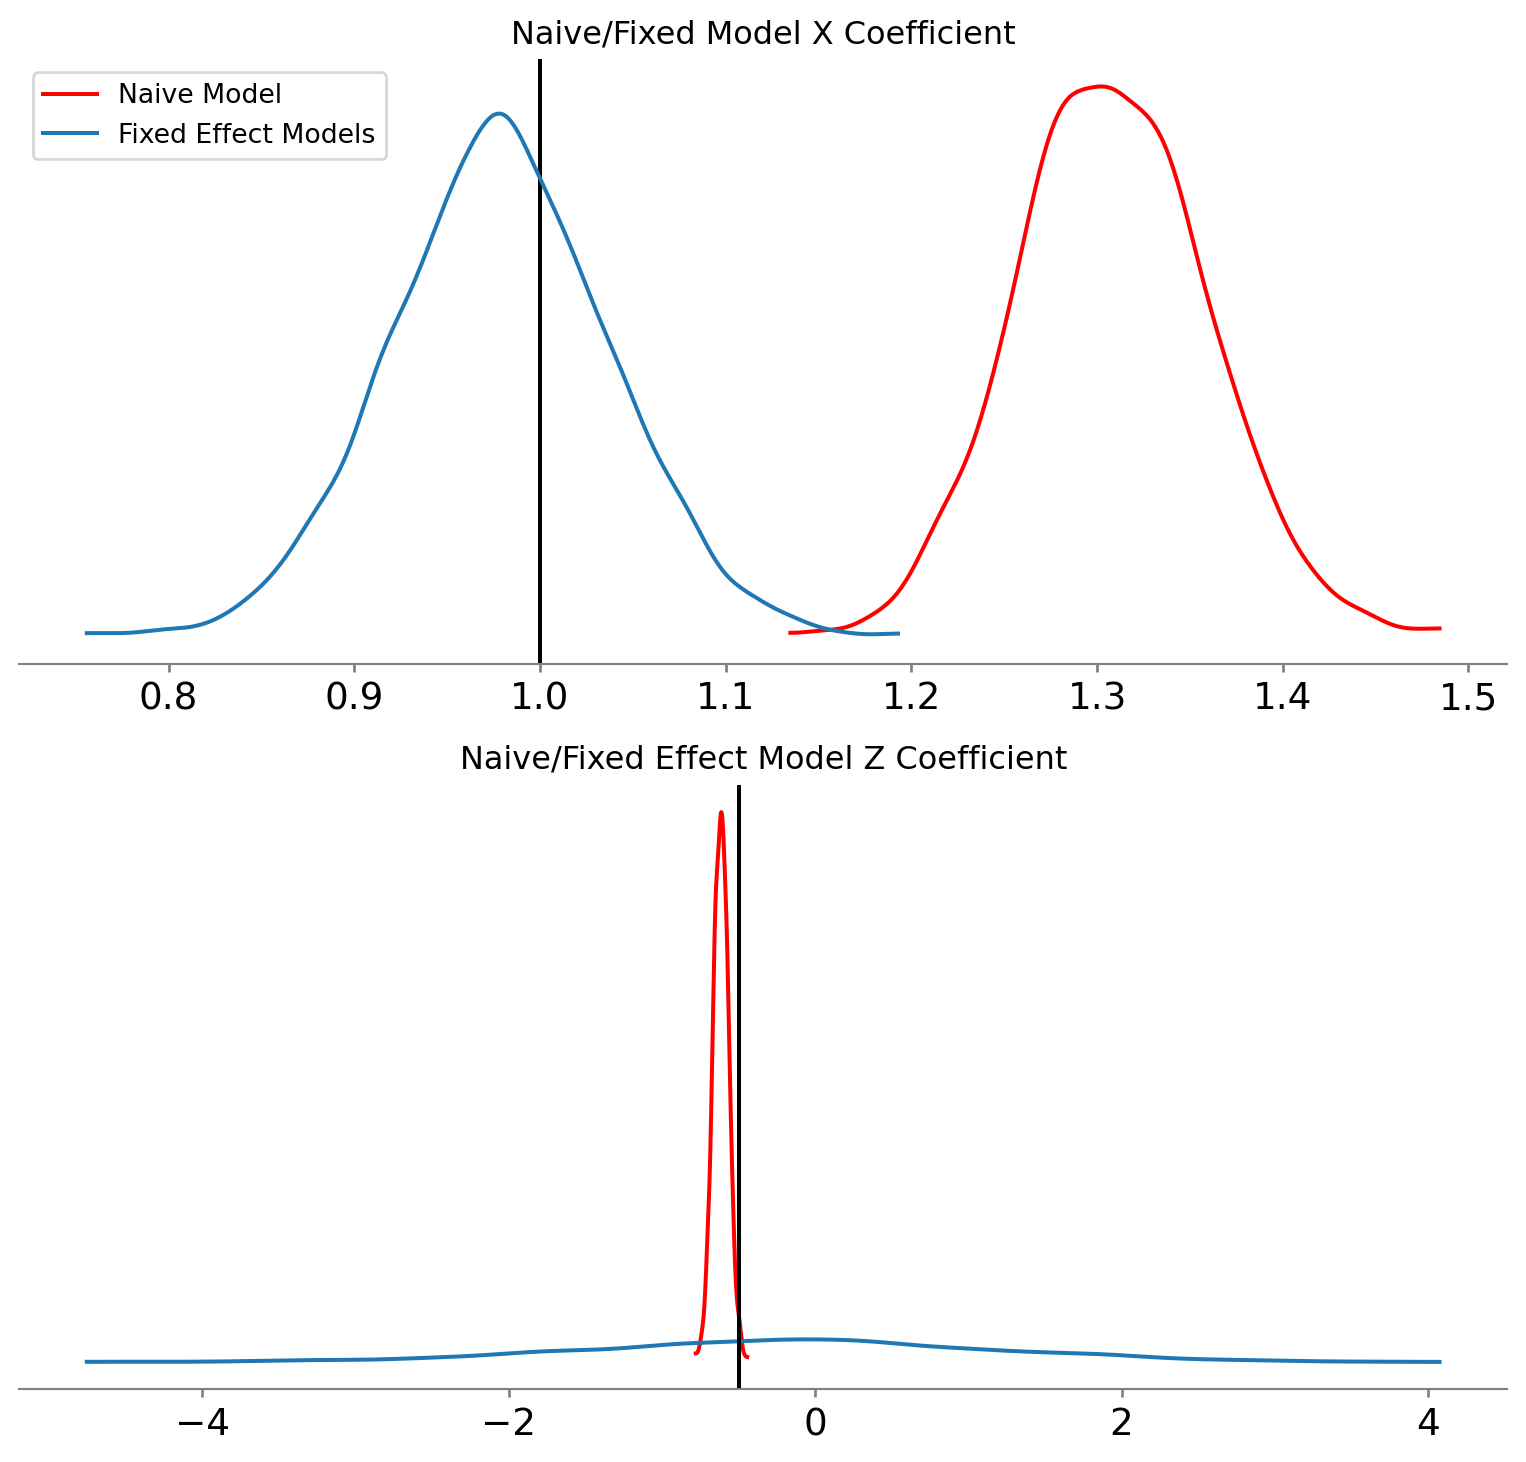

In [9]:
#| code-fold: true

fig, axs = plt.subplots(2, 1, figsize=(10, 9))
axs = axs.flatten()

az.plot_posterior(naive_idata, var_names=['X'], ax=axs[0], 
point_estimate=None,  hdi_prob='hide', color='red', label='Naive Model')
axs[0].axvline(1, color='k')

az.plot_posterior(fixed_effects_idata , var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', label='Fixed Effect Models')
axs[0].set_title("Naive/Fixed Model X Coefficient")

az.plot_posterior(naive_idata, var_names=['Z'], ax=axs[1], point_estimate=None,  hdi_prob='hide', color='red', ref_val_color='black')


az.plot_posterior(fixed_effects_idata , var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide')

axs[1].set_title("Naive/Fixed Effect Model Z Coefficient")
axs[1].axvline(-0.5, color='k');


We now want to try another approach to handle to the group confounding that involves a hierarchical approach to add group level effects to the intercept term. 

### Multilevel Model

The syntax for the random effects model is similar. 


In [10]:
#| output: false

multilevel_model = bmb.Model(f"Y['>.5'] ~ (1 | g) + X + Z", sim_df, 
family="bernoulli")
multilevel_model_idata = multilevel_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:00.687407


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.182393


Transforming variables...


Transformation time = 0:00:00.084828


Computing Log Likelihood...


Log Likelihood time = 0:00:00.478396


This method posits a view that there is a shared underlying process generating each instance of group-behaviour i.e. the realised values of the outcome within each group. In the random effects multilevel model we replace the indivdual fixed effects indicator columns with additional parameters modifying the intercept term. This is the "hierarchy" or multi-level aspect of the specification.


In [11]:
az.summary(multilevel_model_idata, var_names=['X', 'Z', 'Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
X          1.024  0.061   0.905    1.130      0.001    0.001    3821.0   
Z         -0.593  0.163  -0.897   -0.279      0.006    0.004     868.0   
Intercept -0.574  0.194  -0.958   -0.213      0.008    0.005     661.0   

           ess_tail  r_hat  
X            2653.0   1.00  
Z            1324.0   1.00  
Intercept    1277.0   1.01

Next we'll apply the Mundlak device method which adds the group mean back to each observation as a covariate. 

### Mundlak Model

For this technique we augment the model by supplying group an additional column. This column records the group-level means of the "confounded variable" i.e. the variable which is realised under group level influences. Adding the group mean(s) to the model in this sense somewhat absolves of the requirement to include an extra multiplicity of parameters. It's more akin to feature creation than model specification, but it serves the same purpose - it accounts for group level variation and provides a mechanism for the model to learn the appropriate weights to accord each group in the final calculation. 


In [12]:
#| output: false

sim_df['group_mean'] = sim_df.groupby('g')['X'].transform(np.mean)

sim_df['group_mean_Z'] = sim_df.groupby('g')['Z'].transform(np.mean)

mundlak_model = bmb.Model(f"Y['>.5'] ~ (1 | g) + X + Z + group_mean", sim_df, 
family="bernoulli")
mundlak_idata = mundlak_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:00.635703


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.884907


Transforming variables...


Transformation time = 0:00:00.060096


Computing Log Likelihood...


Log Likelihood time = 0:00:00.478622


Mundlak's insight is that this mechanism is akin to adding a whole slew of fixed-effect indicator variables for each group. It is a corrective mechanism for group confounding in our focal variable. We'll see how it allows for more flexible model specifications and has a role in making adjustments to aid identification in causal inference. 


In [13]:
az.summary(mundlak_idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.908  0.140  -2.169   -1.641      0.002    0.002    3795.0   
X          0.950  0.058   0.844    1.062      0.001    0.001    4741.0   
Z         -0.444  0.061  -0.561   -0.336      0.001    0.001    3195.0   

           ess_tail  r_hat  
Intercept    3108.0    1.0  
X            2526.0    1.0  
Z            2696.0    1.0

We can now plot all the parameter recovery models together and we'll see that there are some trade-offs between the fixed effects and random effects varieties of the modelling. 

### Plotting the Comparisons

The parameter recovery exercise shows striking differences across each of the models 


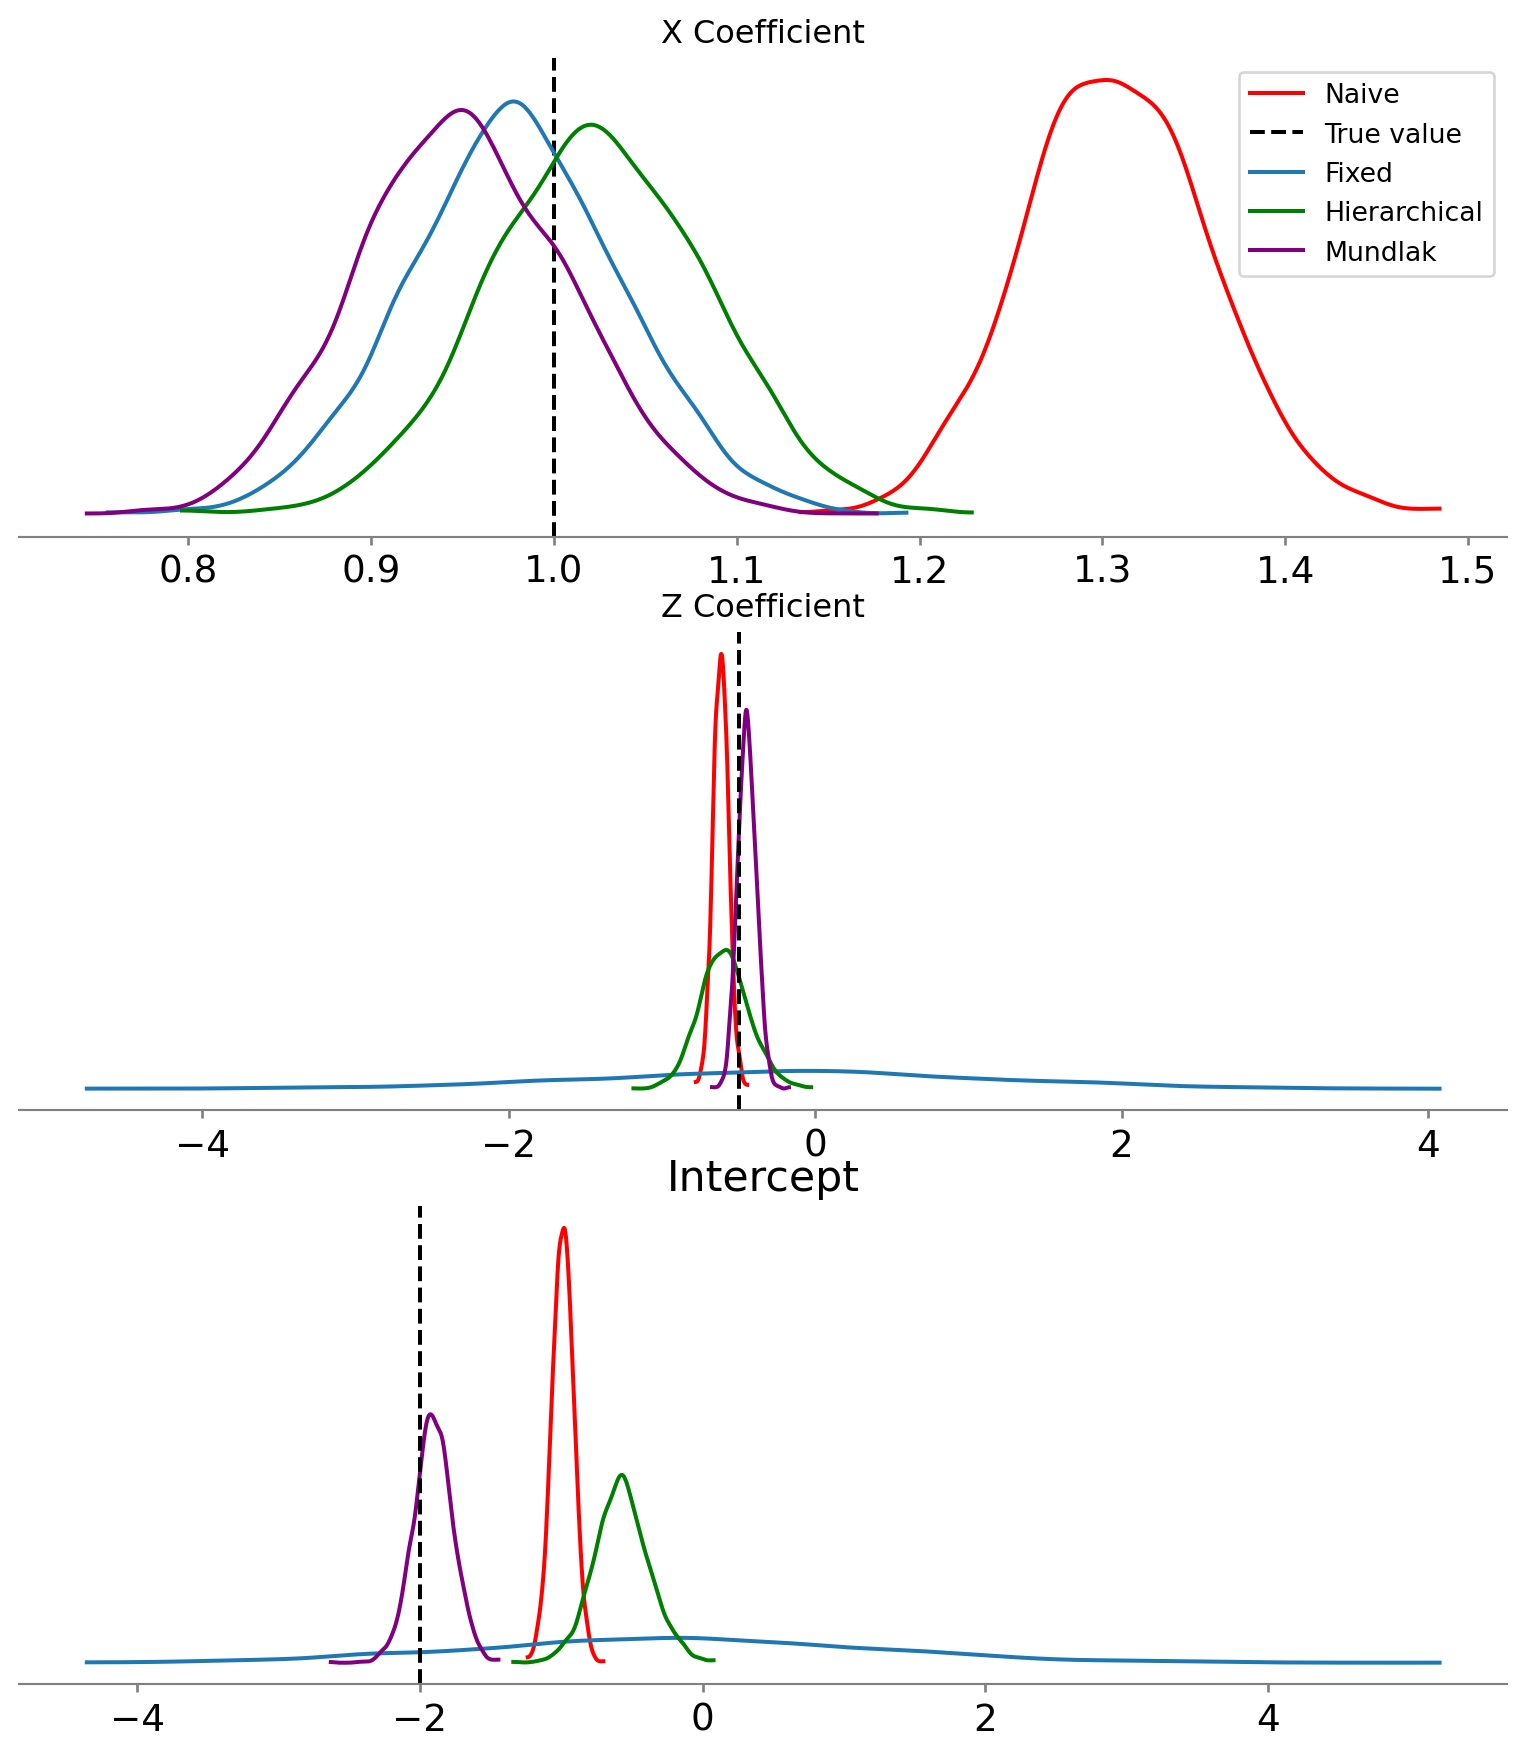

In [14]:
#| code-fold: true

fig, axs = plt.subplots(3, 1, figsize=(10, 11))
axs = axs.flatten()

az.plot_posterior(naive_idata, var_names=['X'], ax=axs[0], 
point_estimate=None, color='red', label='Naive', hdi_prob='hide')
axs[0].axvline(1, color='k', linestyle='--', label='True value')

az.plot_posterior(fixed_effects_idata , var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', label='Fixed')

az.plot_posterior(multilevel_model_idata, var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', color='green', label='Hierarchical')

az.plot_posterior(mundlak_idata, var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', color='purple', label='Mundlak')


axs[0].set_title("X Coefficient")

az.plot_posterior(naive_idata, var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide',  color='red', ref_val_color='black')


az.plot_posterior(fixed_effects_idata , var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide')

az.plot_posterior(multilevel_model_idata, var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide', color='green')

az.plot_posterior(mundlak_idata, var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide', color='purple')

axs[1].set_title("Z Coefficient")
axs[1].axvline(-0.5, color='k', linestyle='--');

az.plot_posterior(naive_idata, var_names=['Intercept'], ax=axs[2], point_estimate=None,  color='red', ref_val_color='black', hdi_prob='hide')


az.plot_posterior(fixed_effects_idata , var_names=['Intercept'], ax=axs[2], point_estimate=None, hdi_prob='hide')

az.plot_posterior(multilevel_model_idata, var_names=['Intercept'], ax=axs[2], point_estimate=None, hdi_prob='hide', color='green')

az.plot_posterior(mundlak_idata, var_names=['Intercept'], ax=axs[2], point_estimate=None, hdi_prob='hide', color='purple')

axs[2].axvline(-2, color='k', linestyle='--');

Importantly, we see that while the fixed effects model is focused on recovering the treatment effect on the $X$ covariate, it does so somewhat at the expense of accuracy on the other systematic components of the model. This focus renders the model less predictively accurate. If we compare the models on the cross-validation score, we see how the hierarchical mundlak model is to be preferred.


In [15]:
compare_df = az.compare({'naive': naive_idata, 'fixed': fixed_effects_idata, 'hierarchical': multilevel_model_idata, 
'mundlak': mundlak_idata})
compare_df

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo      p_loo  elpd_diff        weight  \
mundlak          0 -1209.363087  12.209772   0.000000  9.275045e-01   
hierarchical     1 -1218.531484  27.759140   9.168397  1.455636e-16   
fixed            2 -1221.372842  33.722033  12.009755  4.458315e-02   
naive            3 -1295.421232   2.901514  86.058145  2.791239e-02   

                     se        dse  warning scale  
mundlak       30.206505   0.000000    False   log  
hierarchical  30.411249   4.473882    False   log  
fixed         31.876395   5.519424     True   log  
naive         29.495560  12.996696    False   log

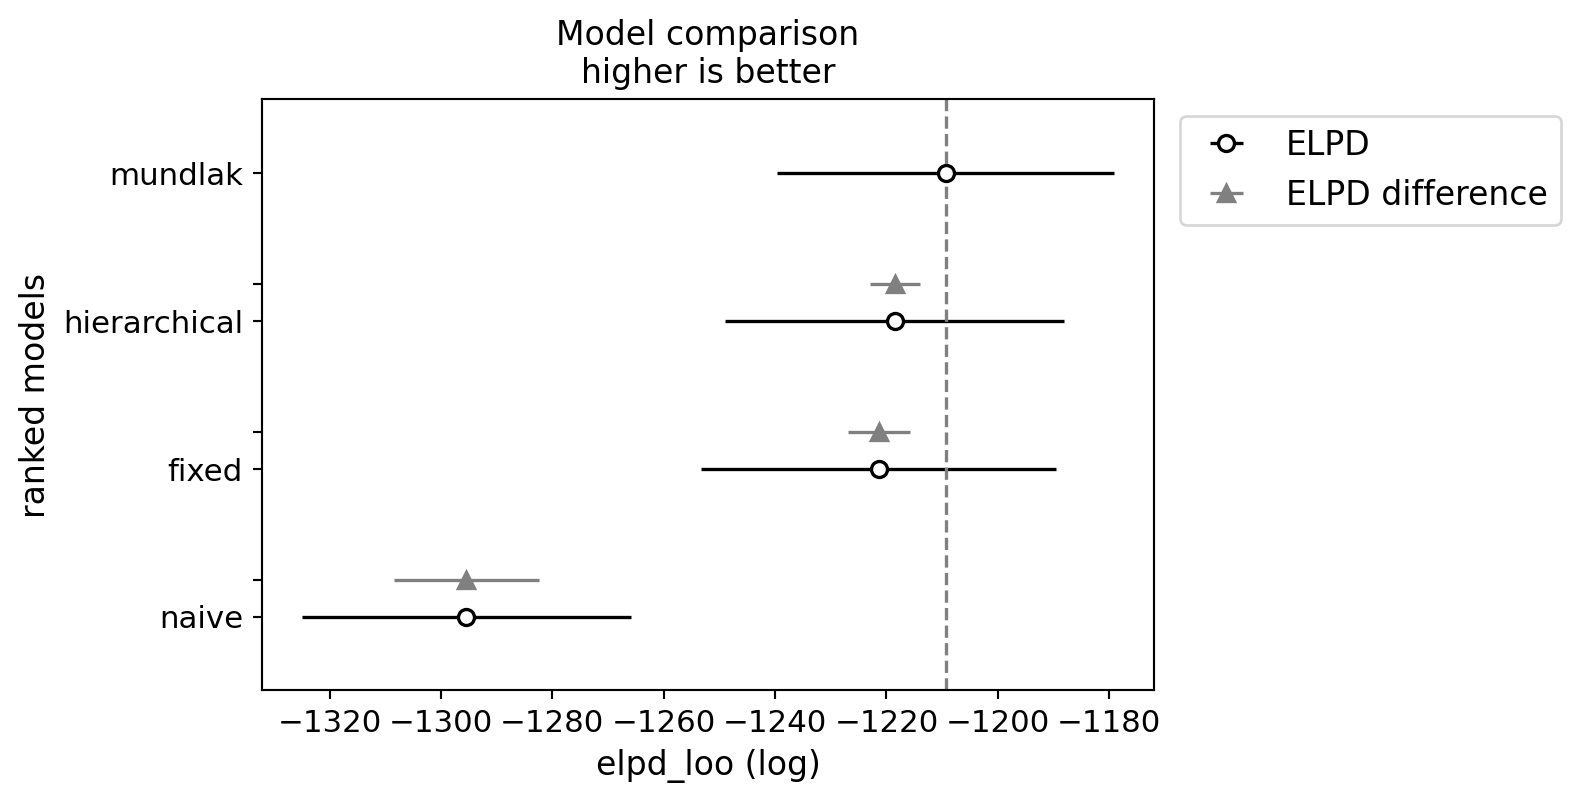

In [16]:
az.plot_compare(compare_df);

This is not the only way to assess viability of the model's functional form but it's not a bad way.

### Full Luxury Bayesian Mundlak Machine

As good Bayesians we might be worry about the false precision of adding simple point estimates for the group mean covariates in the Mundlak model. We can remedy this by explicitly incorporating these values as an extra parameter and adding uncertainty to the draws on these parameters.  


In [17]:
#| output: false

id_indx, unique_ids = pd.factorize(sim_df["g"])

coords = {'ids': list(range(N_groups))}
with pm.Model(coords=coords) as model: 

    x_data = pm.Data('X_data', sim_df['X'])
    z_data = pm.Data('Z_data', sim_df['Z'])
    y_data = pm.Data('Y_data', sim_df['Y'])

    alpha0 = pm.Normal('Intercept', 0, 1)
    alpha_j = pm.Normal('alpha_j', 0, 1, dims='ids')
    beta_xy = pm.Normal('X', 0, 1)
    beta_zy = pm.Normal('Z', 0, 1)

    group_means = pm.Normal('group_means', sim_df.groupby('g')['X'].mean().values, .1, dims='ids')
    group_sigma = pm.HalfNormal('group_sigma', 0.1)
    
    group_mu = pm.Normal('group_mu', (group_means[id_indx]), group_sigma, observed=sim_df['X'].values)

    mu = pm.Deterministic('mu', (alpha0 + alpha_j[id_indx]) + beta_xy*x_data + beta_zy*z_data + group_means[id_indx])
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Binomial("y", n=1, p=p, observed=y_data)

    idata = pm.sample(idata_kwargs={"log_likelihood": True})

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Intercept, alpha_j, X, Z, group_means, group_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Instead of merely adding a new feature to a regression we've added a second likelihood term for the predictor $X$ and seek to model this outcome as a function of the group means. Calibrating the `group_mean` parameter that is also included in our likelihood term for the $Y$ outcome. 


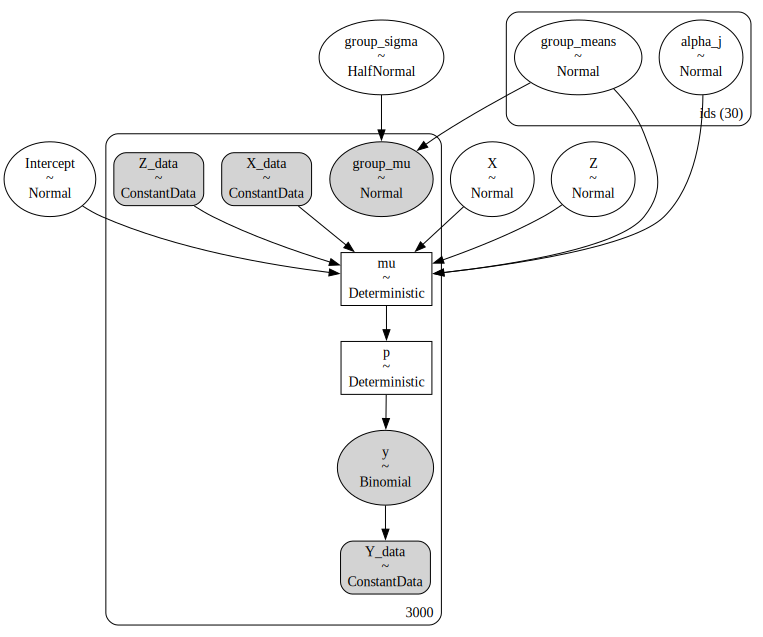

In [18]:
pm.model_to_graphviz(model)

This model bakes more uncertainty into the process assuming a kind of measurement-error model, but again, the focus here is that we need to estimate a corrective adjustment factor for confounding effects that impact the estimation of impact due to our focal variable $X$. It's perhaps easier to see in this parameter recovery exercise than it is in real cases, but wherever we suspect plausible group level confounding you should consider Mundlak adjustments alongside your go-to fixed effects or random effects controls. 


In [19]:
az.summary(idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.876  0.208  -2.256   -1.479      0.006    0.005    1034.0   
X          0.989  0.058   0.870    1.090      0.001    0.001    6479.0   
Z         -0.519  0.174  -0.854   -0.198      0.005    0.003    1406.0   

           ess_tail  r_hat  
Intercept    1937.0    1.0  
X            3031.0    1.0  
Z            2289.0    1.0

You can see it also recovers the correct parameter specifcation well. 

### Recap

We've just seen a number of different modelling specifications that attempt to deal with the threat of group level confounding. We'll now look at a case-study where group level confounding remains highly plausible and the choice of estimation routine is not trivial. This will highlight aspects of how what we seek learn determines our model choice. 

## Nested Groups, Hierarchies and Fixed Effects

We've seen how various attempts to account for the group effects can more or less recover the parameters of a complex data generating process with group confounding. Now we want to look at a case where we can have interacting group effects at multiple levels. 

![Structure](hierarchy.png)

### Pupils within Class Rooms within Schools

A natural three level group hierarchy occurs in the context of educational organisations and business org-charts. We can use this fact to interrogate briefly how inferential statements about treatment effects vary as a function of what and how we control for group level variation. We draw the following data set from _Linear Mixed Models: A Practical Guide Using Statistical Software_.


In [20]:
df = pd.read_csv('classroom.csv')
df['class_mean'] = df.groupby(['classid'])['mathprep'].transform(np.mean)
df['school_mean'] = df.groupby(['schoolid'])['mathprep'].transform(np.mean)
df.head()

sex  minority  mathkind  mathgain   ses  yearstea  mathknow  housepov  \
0    1         1       448        32  0.46       1.0       NaN     0.082   
1    0         1       460       109 -0.27       1.0       NaN     0.082   
2    1         1       511        56 -0.03       1.0       NaN     0.082   
3    0         1       449        83 -0.38       2.0     -0.11     0.082   
4    0         1       425        53 -0.03       2.0     -0.11     0.082   

   mathprep  classid  schoolid  childid  class_mean  school_mean  
0      2.00      160         1        1        2.00     2.909091  
1      2.00      160         1        2        2.00     2.909091  
2      2.00      160         1        3        2.00     2.909091  
3      3.25      217         1        4        3.25     2.909091  
4      3.25      217         1        5        3.25     2.909091

The data has three distinct levels: (1) the child or pupil and their demographic attributes and outcome variable `mathgain`, (2) the classroom and the teacher level attributes such as their experience `yearstea` and a record of their mathematics courses taken `mathprep`, (3) school and neighbourhood level with features describing poverty measures in the vicinity `housepov`. 

We'll plot the child's outcome `mathgain` against the `mathprep` and distinguish the patterns by school.  


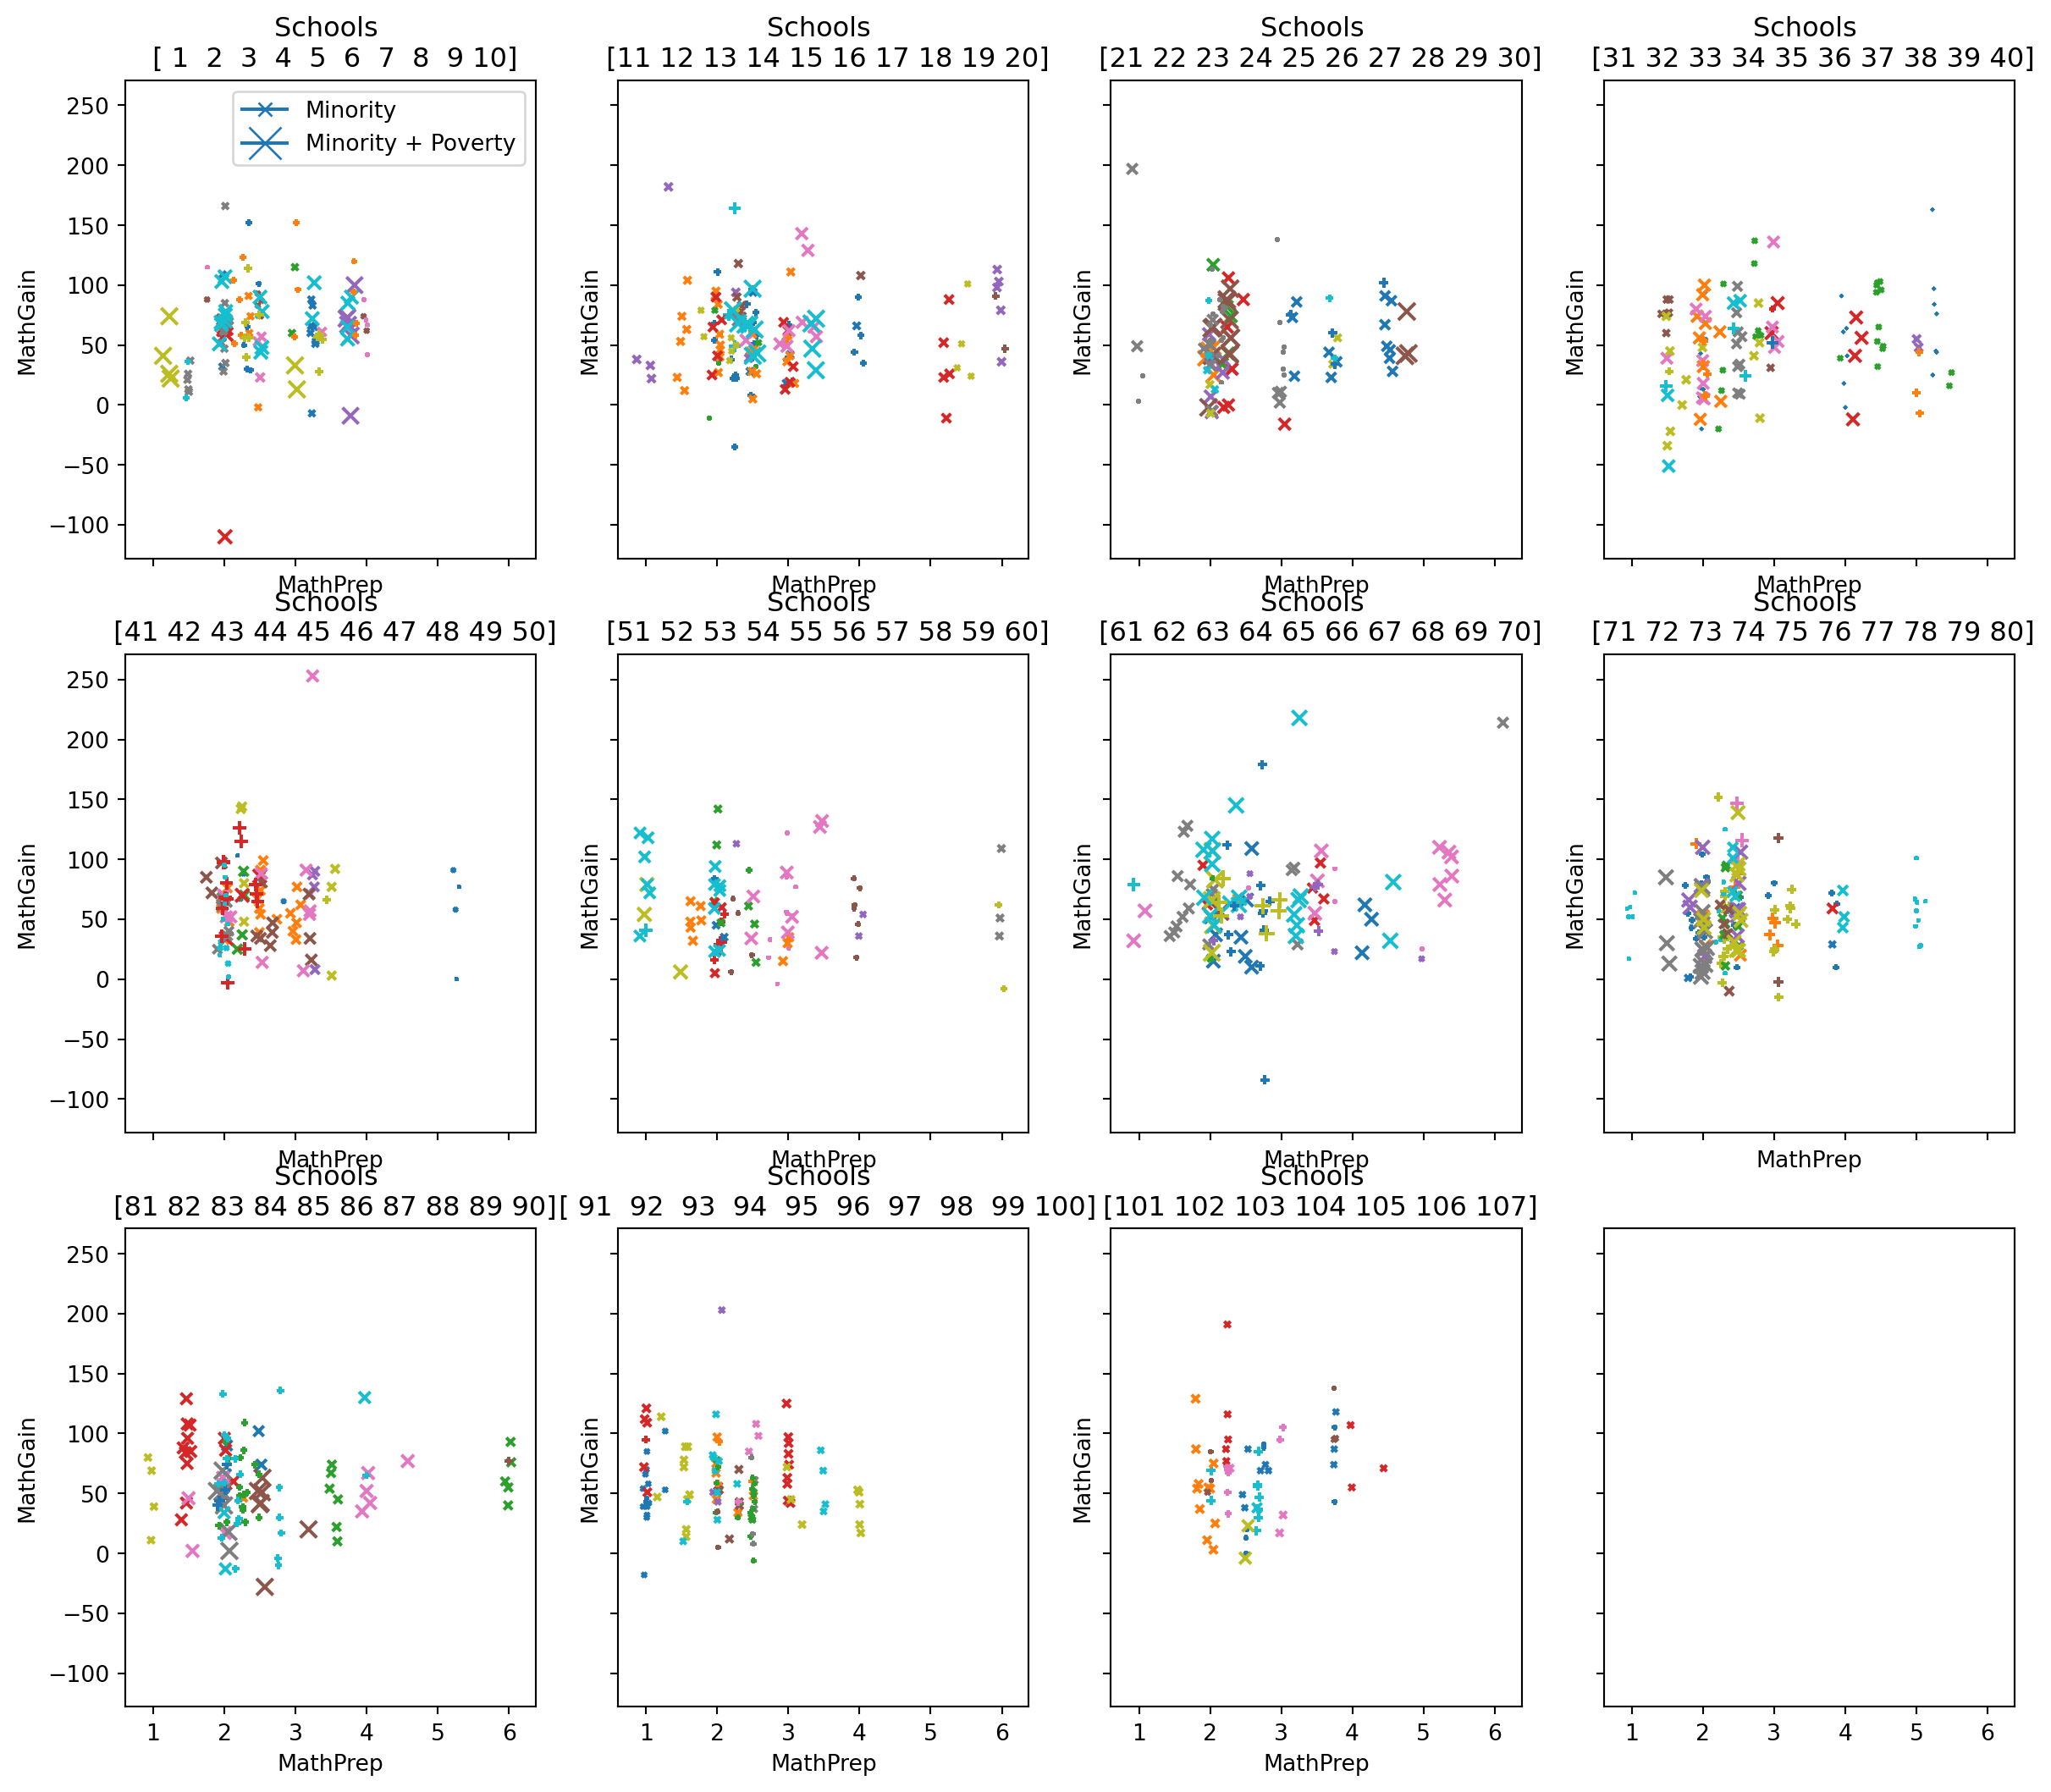

In [21]:
#| code-fold: true

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

legend_elements = [Line2D([0], [0], marker='x', label='Minority', markerfacecolor='k'),
                   Line2D([0], [0], marker='x', label='Minority + Poverty', markersize=14, markerfacecolor='k'), 
                   ]

schools = df['schoolid'].unique()
schools_10 = [schools[i:i+10] for i in range(0, len(schools), 10)]
fig, axs = plt.subplots(3,4, figsize=(15, 13), 
sharey=True, sharex=True)
axs = axs.flatten()
mkr_dict = {1: 'x', 0: '+'}
for s, ax in zip(schools_10, axs):
    temp = df[df['schoolid'].isin(s)]
    temp['m'] = temp['minority'].map(mkr_dict)
    for m in temp['m'].unique():
        temp1 = temp[temp['m'] == m]
        ax.scatter(rand_jitter(temp1['mathprep']), 
        temp1['mathgain'], 
        c=temp1['schoolid'], cmap='tab10', 
        s=temp1['housepov']*100, 
        marker = m)
    ax.set_title(f"Schools \n {s}");
    ax.set_xlabel("MathPrep")
    ax.set_ylabel("MathGain")

axs[0].legend(handles=legend_elements);


We've plotted here the individual student outcomes. We've sized the dots by the poverty in their neighbourhoods and differentiated the markers by whether the student was in minority group. There are, in short, reasons here to worry about group-level confounding. There is a small number of observed students per school so the individual school level distributions show some extreme outliers but the overall distribution nicely converges to an approximately normal symmetric shape.


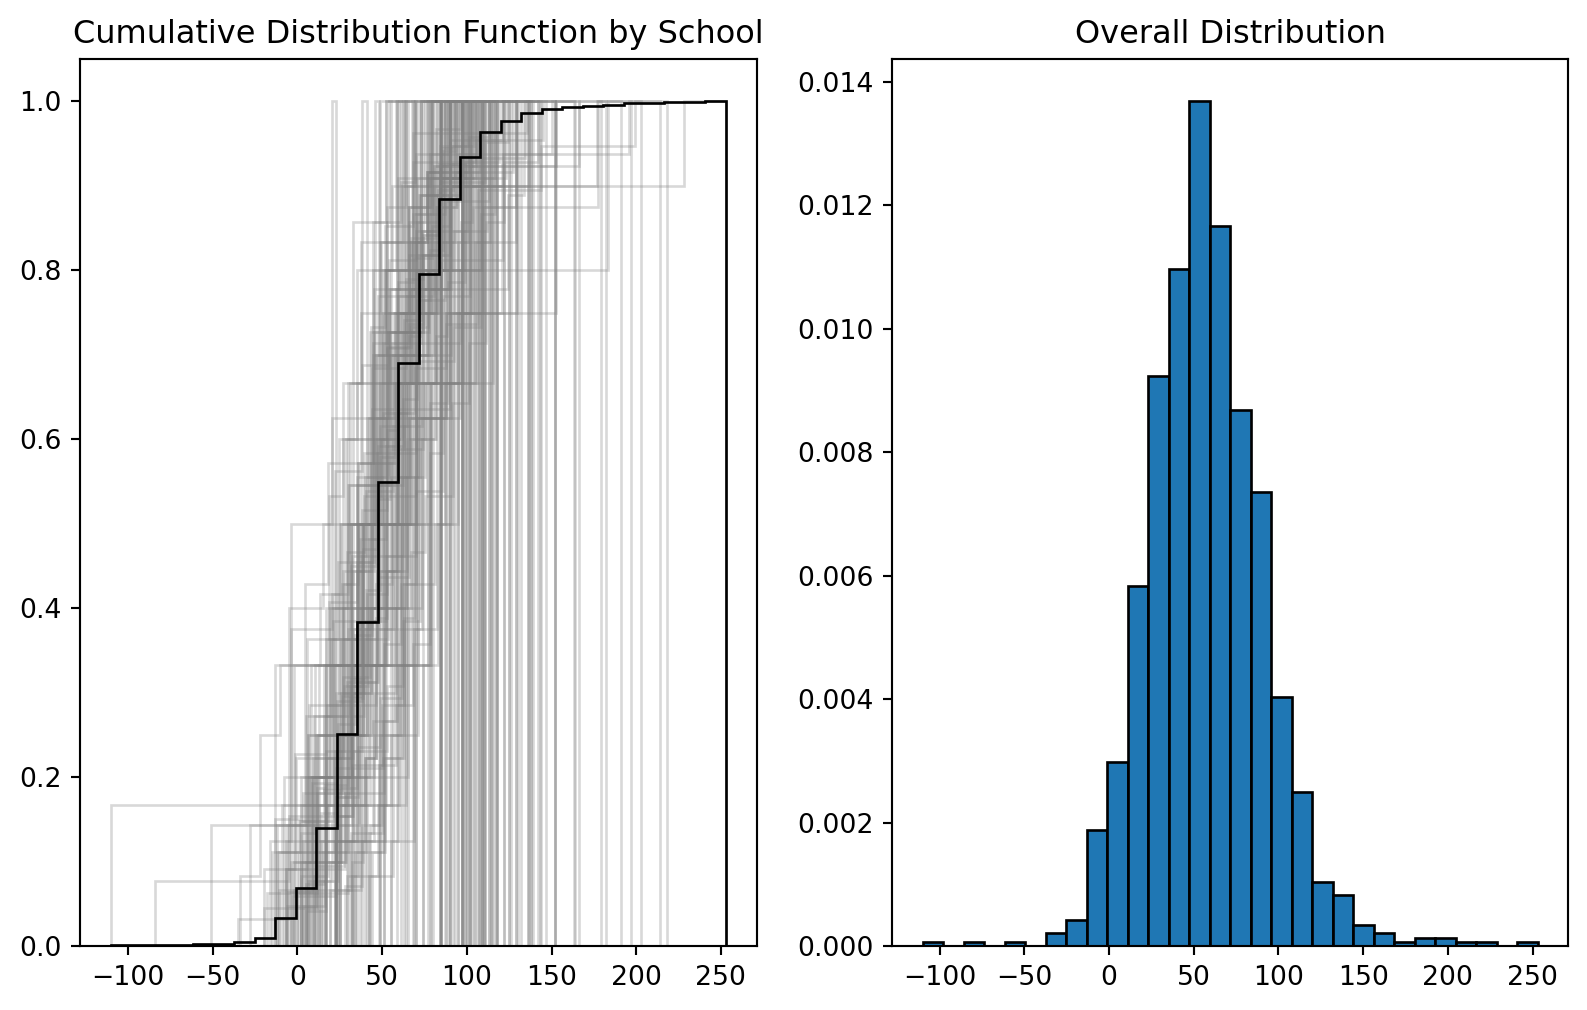

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs = axs.flatten()
for school in schools:
    temp = df[df['schoolid'] ==school]
    axs[0].hist(temp['mathgain'], color='grey', alpha=0.3, density=True, histtype='step', cumulative=True)

axs[0].hist(df['mathgain'], bins=30, ec='black', density=True, cumulative=True, histtype='step')
axs[1].hist(df['mathgain'], bins=30, ec='black', density=True, cumulative=False)
axs[0].set_title("Cumulative Distribution Function by School")
axs[1].set_title("Overall Distribution");

With these kinds of structures we need to be careful in how we evaluate any treatment effects when there are reasons to believe in group-level effects that impact the outcome variable. Imagine the true treatment effect is a sprinter running too fast to cleanly measure - each group interaction effect is added to his load as a weight. Enough weights absorb enough of the variation in the treatment that he is dragged to a crawl. Whatever movement he can make while dragging this burden is the effect we attribute to the treatment. Or put another way - the effects of various group interactions will modify the treatment effectiveness in some way and unless we account for this impact in our model, then the inferences regarding the treatment will be clouded. 

### Interaction Effects and Nuisance Parameters

Not all possible interactions will be present in the data. But if we specify the model to account for various interactions we may explode the number of parameters beyond the number of data points. This can cause issues in estimation routines and requires consideration about what the group parameters are aimed at capturing. 

Why add covariates for group-membership when no observation reflects outcomes in that group? We cannot learn anything about these cases. At least if we add the group effects as a hierarchical random effect we induce shrinkage on the parameter estimates towards the mean of the hierarchical parameter in the model. This means that when predicting on "new" data with examples of these missing cases we can predict a sensible default. The distinction rests in the role we have in mind for these tools. If we seriously commit to the idea that group variation reflects a real "common" process in the larger population and we want to learn about that over-arching process then we deploy a random effects model. But if we only see these as tools for accounting to variation in the sample, allowing us to pin down an alternative focal estimate then the group indicator covariates are just "nuisance" parameters and missing cases are irrelevant.  


::: {.callout-tip}
## Philosophical Digression
This last point skips a little quickly over a fundamental feature of interpreting these models. If we aim to interpret these models as reflecting a common process across these groups that exists in a "population", then we're endorsing an inferential view that extends beyond the sample. We're actively seeking to learn a general truth about the data generating process which we deem to be adequately expressed in our model. If we seek to "soak up" the variation due to group effects, we're treating these group effects as noise in the sample data and making inferential commitments only about the focal parameter in the model. This approach to learning differentiates approaches to credible causal inference. On the one hand, fixing your estimand and designing estimators to specifically capture that estimate seems like a modest and compelling strategy. On the other hand if your model ignores aspects of underlying phenomena or fails to retrodict the observable data, it's dubious as to why anyone would trust its output. 
:::


To see the extent of redundany we can examine the dimensions of the covariate matrices that result from including more or less interaction terms. 


In [23]:
y, X = dmatrices("mathgain ~ mathprep + C(schoolid)+ C(classid)", df, return_type="dataframe")
print(X.shape)

y, X1 = dmatrices("mathgain ~ mathprep + C(schoolid)/C(classid)", df, return_type="dataframe")
print(X1.shape)


y, X2 = dmatrices("mathgain ~ mathprep + C(schoolid):C(childid)", df, return_type="dataframe")
print(X2.shape)

(1190, 419)


(1190, 33385)


(1190, 127331)


We see here how different ways in which to account for group level variation and interaction effects lead to vastly inflated feature matrices. However not all interaction terms matter, or put another way... nor all the possible interactions feature in the data. So we have likely inflated the data matrix beyond necessity. 

Here we define a helper function to parse a complex interaction formula, remove the columns entirely composed of zeros and return a new formula and dataframe which has a suitable range of features to capture the variation structures in the data. 


In [24]:
def make_interactions_df(formula, df):
    y, X = dmatrices(formula, df, return_type="dataframe")
    n = X.shape[1]
    X = X[X.columns[~(np.abs(X) < 1e-12).all()]]
    n1 = X.shape[1]
    target_name = y.columns[0]
    d = pd.concat([y, X], axis=1)
    d.drop(['Intercept'], axis=1, inplace=True)
    d.columns = [c.replace('[', '').replace(']','').replace('C(', '').replace(')', '').replace('.', '_').replace(':', '_') for c in d.columns]
    cols = ' + '.join([col for col in d.columns if col != target_name])
    formula = f"{target_name} ~ {cols}"
    print(f"""Size of original interaction features: {n} \nSize of reduced feature set: {n1}""")
    return formula, d

formula, interaction_df = make_interactions_df("mathgain ~ mathprep + C(schoolid):C(childid)", df)

interaction_df.head()

Size of original interaction features: 127331 
Size of reduced feature set: 2370


mathgain  childidT_2  childidT_3  childidT_4  childidT_5  childidT_6  \
0      32.0         0.0         0.0         0.0         0.0         0.0   
1     109.0         1.0         0.0         0.0         0.0         0.0   
2      56.0         0.0         1.0         0.0         0.0         0.0   
3      83.0         0.0         0.0         1.0         0.0         0.0   
4      53.0         0.0         0.0         0.0         1.0         0.0   

   childidT_7  childidT_8  childidT_9  childidT_10  ...  \
0         0.0         0.0         0.0          0.0  ...   
1         0.0         0.0         0.0          0.0  ...   
2         0.0         0.0         0.0          0.0  ...   
3         0.0         0.0         0.0          0.0  ...   
4         0.0         0.0         0.0          0.0  ...   

   schoolidT_107_childid1182  schoolidT_107_childid1183  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1184  schoolidT_107_childid1185  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1186  schoolidT_107_childid1187  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1188  schoolidT_107_childid1189  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1190  mathprep  
0                        0.0      2.00  
1                        0.0      2.00  
2                        0.0      2.00  
3                        0.0      3.25  
4                        0.0      3.25  

[5 rows x 2370 columns]

We have reduced the number of interactions by an order of magnitude! We can now fit a regression model to the revised feature matrix. 

### Comparing Interaction Models

Consider the variation in the coefficient values estimated for `mathprep` as we add more and more interaction effects. The addition of interaction effects generates a large number of completely 0 interaction terms which we remove here. 


In [25]:
formulas = ["""mathgain ~ mathprep + C(schoolid)""",
""" mathgain ~ mathprep + school_mean*class_mean""" , 
""" mathgain ~ mathprep + mathkind + sex + school_mean*class_mean""" , 
"""mathgain ~ mathprep + C(schoolid) + C(classid)""", 
"""mathgain ~ mathprep + C(schoolid)*C(classid)""",
"""mathgain ~ mathprep + C(classid):C(childid)""", 
]

estimates_df = []
for f in formulas:
    formula, interaction_df = make_interactions_df(f, df)
    result = smf.ols(formula, interaction_df).fit()
    estimates = [[result.params['mathprep']], list(result.conf_int().loc['mathprep', :]), [formula]]
    estimates = [e for est in estimates for e in est]
    estimates_df.append(estimates)

estimates_df = pd.DataFrame(estimates_df, columns=['mathprep_estimate', 'lower bound', 'upper bound', 'formula'])

estimates_df

Size of original interaction features: 108 
Size of reduced feature set: 108
Size of original interaction features: 5 
Size of reduced feature set: 5
Size of original interaction features: 7 
Size of reduced feature set: 7
Size of original interaction features: 419 
Size of reduced feature set: 419


Size of original interaction features: 33385 
Size of reduced feature set: 728


Size of original interaction features: 371281 
Size of reduced feature set: 2376


/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


mathprep_estimate  lower bound  upper bound  \
0           1.060768    -1.435118     3.556655   
1           1.789413    -1.587051     5.165876   
2           0.904018    -2.056505     3.864541   
3           2.948546     0.601150     5.295942   
4           3.545931     1.359793     5.732068   
5           2.303187          NaN          NaN   

                                             formula  
0  mathgain ~ schoolidT_2 + schoolidT_3 + schooli...  
1  mathgain ~ mathprep + school_mean + class_mean...  
2  mathgain ~ mathprep + mathkind + sex + school_...  
3  mathgain ~ schoolidT_2 + schoolidT_3 + schooli...  
4  mathgain ~ schoolidT_2 + schoolidT_3 + schooli...  
5  mathgain ~ childidT_2 + childidT_3 + childidT_...

The point here (perhap obvious) is that the estimate of treatment effects due to some policy or programme can be differently understood when the regression model is able to account for increasing aspects of individual variation. Choice of the __right__ way to "saturate" your regression specification are at the heart of causal inference. The right control structures determine the freedom available to vary your focal treatment effect parameter. 

We will consider a number of specifications below that incorporate these group effects in a hierarchical model which nests the effect of class-membership within school membership. This choice allows us to control for group specific interactions without worrying about over-indexing on the observed interaction effects in the sample data requiring that we handle more fixed effects parameters than we have data points. 

In what follows we'll specify a nested approach to the parameter specifcation using a random effects model. The idea here is that classes are already implicitly nested in schools and so we don't need to add parameters for classes at multiple schools. Additionally we're positing that there is independent interest in the effectiveness school/class effects i.e. the degree to which variation in a school/class nest can account for variation in the outcome. 

#### Minimal Model


In [26]:
#| output: false
#| 
model = bmb.Model(f"mathgain ~ mathprep + (1 | schoolid / classid)", df)
idata = model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.925054


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:03.923360


Transforming variables...


Transformation time = 0:00:03.127514


Computing Log Likelihood...


Log Likelihood time = 0:00:00.362254


The model specification here is deliberately minimalist we want to observe how much of the variation in the outcome can be accounted for by solely adding extensive controls for interactions of group level effects and the treatment but ignoring all else. 


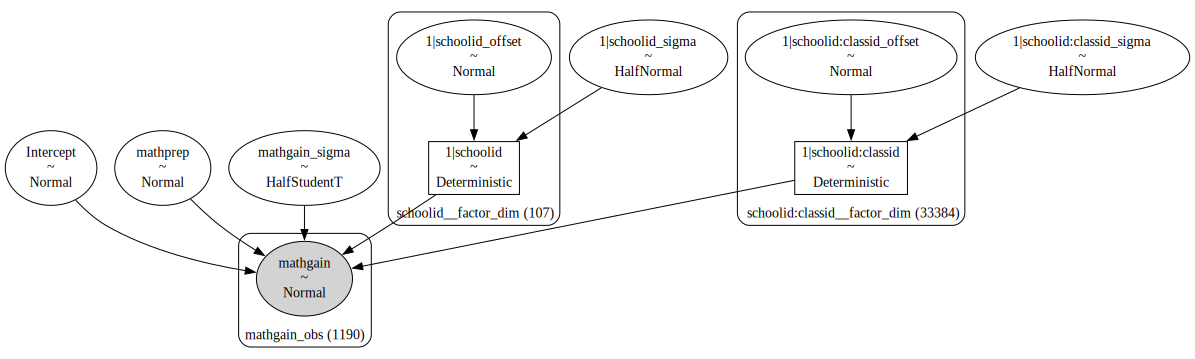

In [27]:
model.graph()

We can see the derived sigma parameters here which can be understood as partialling out the variance of the outcome into components due to those group level effects and the unexplained residuals. 


In [28]:
az.summary(idata, var_names=['Intercept', '1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma', 'mathprep'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 52.496  3.510  45.874   59.025      0.071    0.050   
1|schoolid_sigma           8.348  2.186   4.191   12.463      0.128    0.090   
1|schoolid:classid_sigma   9.854  2.595   4.917   14.737      0.172    0.122   
mathgain_sigma            32.140  0.791  30.721   33.692      0.022    0.015   
mathprep                   1.902  1.241  -0.274    4.361      0.025    0.018   

                          ess_bulk  ess_tail  r_hat  
Intercept                   2462.0    2742.0   1.00  
1|schoolid_sigma             334.0     342.0   1.01  
1|schoolid:classid_sigma     277.0     194.0   1.01  
mathgain_sigma              1334.0    1761.0   1.00  
mathprep                    2502.0    2310.0   1.00

Note here the relative proportion of the school specifc variances `1|schoolid_sigma` to the overall variance of the residuals `mathgain_sigma`.

### Calculating the IntraClass Correlation Coefficient

These models faciliate the calculation of the ICC statistics which is a measure of "explained variance". The thought is to gauge the proportion of variance ascribed to one set of random effects over and above the total estimated variance in the baseline model, including the residuals `mathgain_sigma`.


In [29]:
a = idata['posterior']['1|schoolid_sigma']**2

b = (idata['posterior']['1|schoolid:classid_sigma']**2 + idata['posterior']['1|schoolid_sigma']**2)

c = (idata['posterior']['1|schoolid:classid_sigma']**2 + idata['posterior']['1|schoolid_sigma']**2 + idata['posterior']['mathgain_sigma']**2)

(a / c).mean().item() 


0.06124184394963211

In [30]:
((a + b) / c).mean().item()

0.2078936596304421

We can see here that the interaction terms do seem to account for a goodly portion of the variance in the outcome and we ought to consider retaining their inclusion in our modelling work. The structure of the problem drives us towards their inclusion. Class/school effects are going to absorb a sufficient portion of the variation. So they merit study in their own right, lest the individual class/school dynamics obscure the effectiveness of the `mathprep` treatment. Similarly, it's likely valuable to consider the efficacy of the average class/school in a wider policy conversation. 

### Augmenting the Models

Next we augment our model with more pupil level control variables aiming to pin down some of the aspects of the variation in the outcome. 

#### Adding Pupil Fixed Effects
Here we add these fixed effects population parameters. But note they are not merely devices for controlling variance in the outcome, they're interpretation is likely of independent interest. 


In [31]:
#| output: false

model_fixed = bmb.Model(f"mathgain ~  sex + minority + ses + mathprep + (1 | schoolid / classid)", df)
idata_fixed = model_fixed.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.938108


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:15.111860


Transforming variables...


Transformation time = 0:00:03.410892


Computing Log Likelihood...


Log Likelihood time = 0:00:00.292987


In [32]:
az.summary(idata_fixed, var_names=['Intercept', 'sex', 'minority', 'ses', 'mathprep',
'1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 53.560  4.227  45.203   61.043      0.085    0.060   
sex                       -2.350  2.000  -6.394    1.116      0.029    0.026   
minority                   0.155  2.653  -5.057    4.814      0.057    0.040   
ses                        0.971  1.449  -1.554    3.916      0.024    0.020   
mathprep                   1.930  1.251  -0.403    4.272      0.025    0.019   
1|schoolid_sigma           8.610  2.121   4.543   12.610      0.116    0.082   
1|schoolid:classid_sigma   9.966  2.371   5.404   14.371      0.124    0.088   
mathgain_sigma            32.115  0.776  30.653   33.586      0.020    0.014   

                          ess_bulk  ess_tail  r_hat  
Intercept                   2493.0    2936.0   1.00  
sex                         4720.0    2744.0   1.00  
minority                    2177.0    2452.0   1.00  
ses                         3713.0    2951.0   1.00  
mathprep                    2450.0    2475.0   1.00  
1|schoolid_sigma             379.0     304.0   1.01  
1|schoolid:classid_sigma     380.0     505.0   1.01  
mathgain_sigma              1444.0    2269.0   1.00

Now we add a further class level control. 

#### Adding More Class and Pupil Level Fixed Effects


In [33]:
#| output: false

model_fixed_1 = bmb.Model(f"mathgain ~ mathkind + sex + minority + ses + yearstea +	mathknow + mathprep + (1 | schoolid / classid)", df.dropna())
idata_fixed_1 = model_fixed_1.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:01.149710


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:15.985734


Transforming variables...


Transformation time = 0:00:03.215201


Computing Log Likelihood...


Log Likelihood time = 0:00:00.408731


In [34]:
az.summary(idata_fixed_1, var_names=['Intercept', 
'mathkind', 'sex', 'minority', 'ses', 'yearstea', 'mathknow', 'mathprep','1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma'])

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
Intercept                 281.719  11.985  260.116  304.852      0.216   
mathkind                   -0.474   0.023   -0.519   -0.432      0.000   
sex                        -1.318   1.719   -4.343    2.093      0.026   
minority                   -7.860   2.465  -12.619   -3.301      0.044   
ses                         5.400   1.268    3.042    7.780      0.020   
yearstea                    0.043   0.117   -0.169    0.276      0.002   
mathknow                    1.904   1.176   -0.219    4.227      0.027   
mathprep                    1.083   1.159   -1.192    3.174      0.023   
1|schoolid_sigma            8.563   1.764    5.115   11.840      0.080   
1|schoolid:classid_sigma    9.288   1.816    5.744   12.577      0.089   
mathgain_sigma             26.787   0.666   25.537   28.002      0.015   

                          mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                   0.153    3065.0    2878.0   1.00  
mathkind                    0.000    3193.0    2609.0   1.00  
sex                         0.024    4393.0    2989.0   1.00  
minority                    0.031    3148.0    2553.0   1.00  
ses                         0.014    3879.0    3011.0   1.00  
yearstea                    0.002    2579.0    2594.0   1.00  
mathknow                    0.019    1910.0    2490.0   1.00  
mathprep                    0.016    2586.0    2525.0   1.00  
1|schoolid_sigma            0.057     524.0     614.0   1.01  
1|schoolid:classid_sigma    0.063     419.0     765.0   1.01  
mathgain_sigma              0.010    2049.0    2344.0   1.00

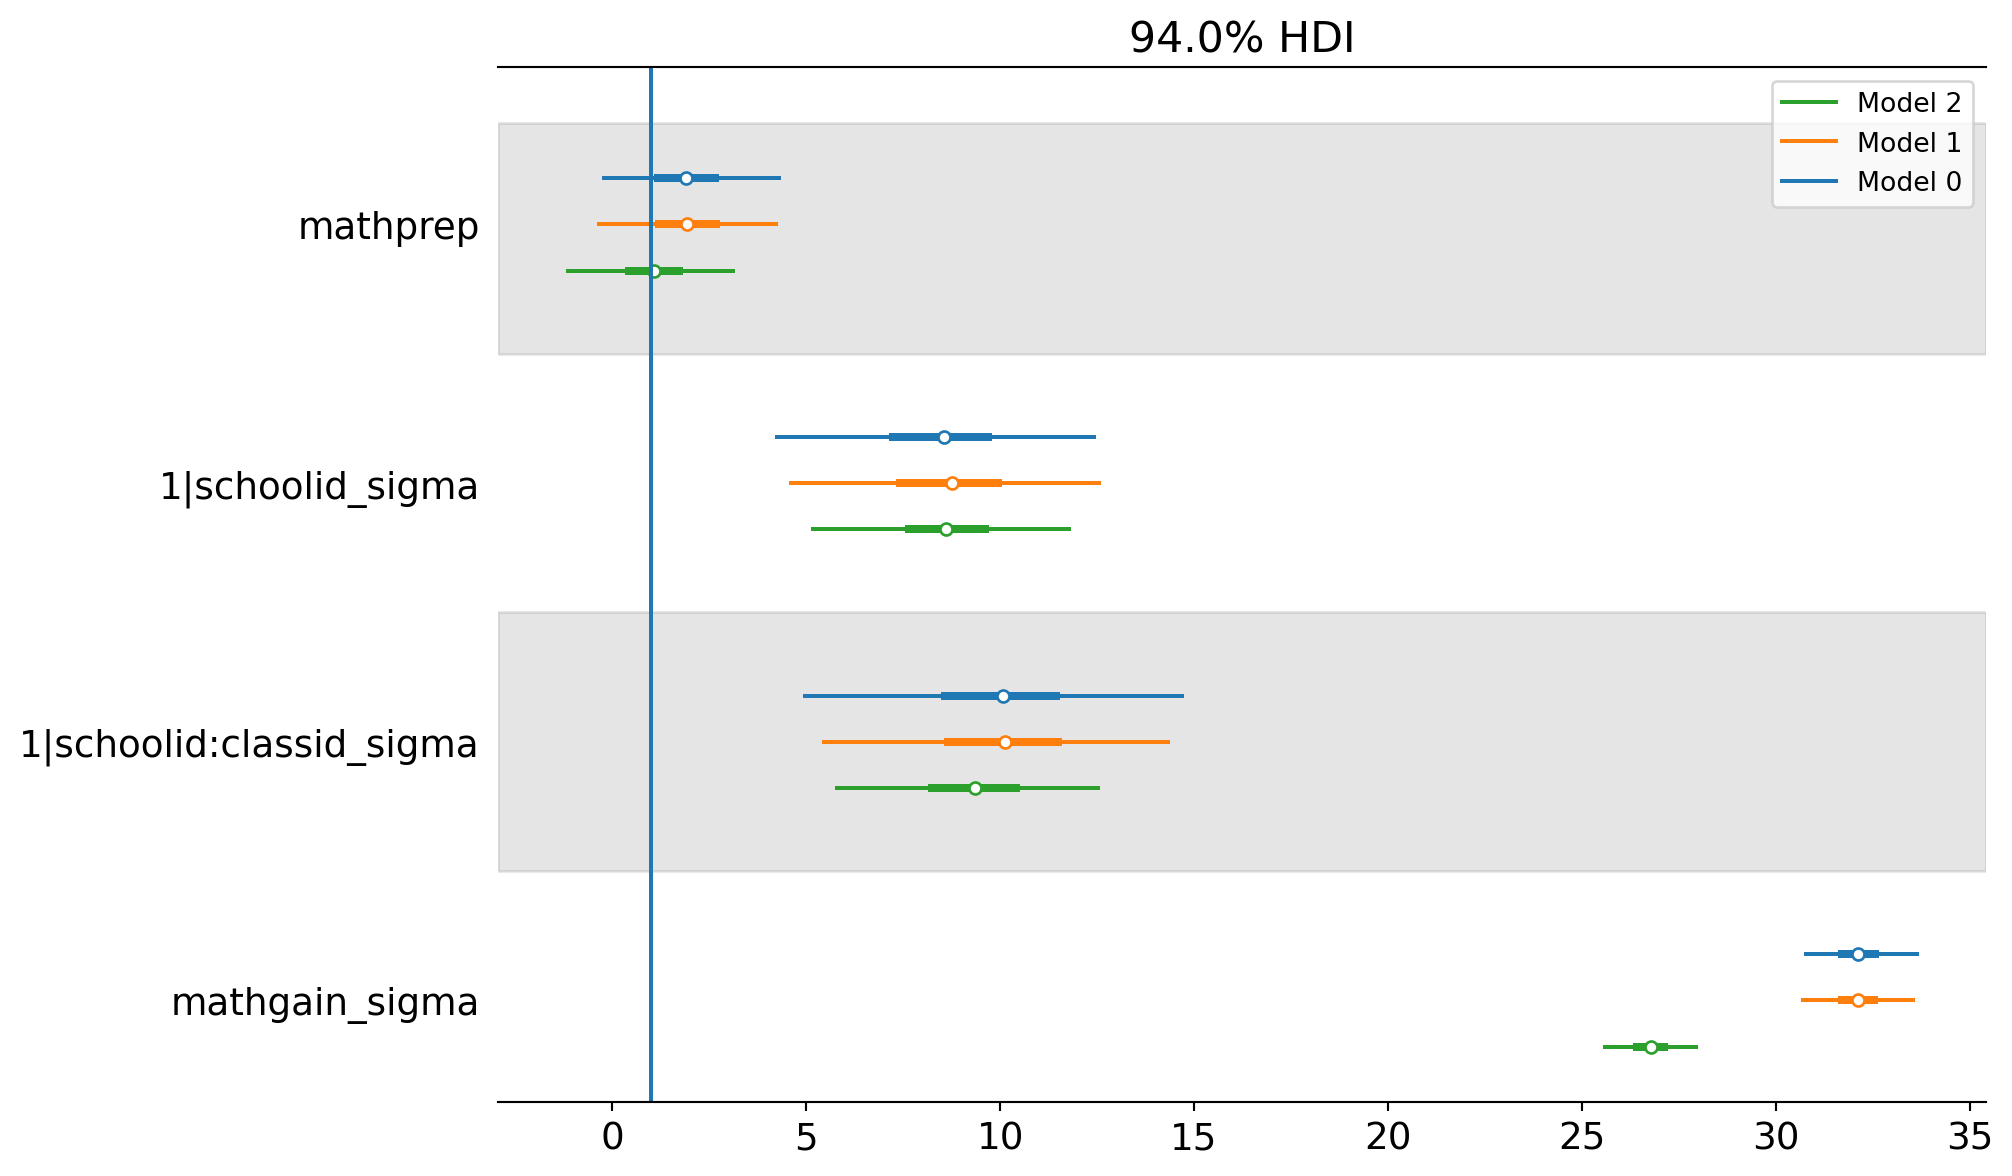

In [35]:
fig, ax = plt.subplots(figsize=(10, 7))
az.plot_forest([idata, idata_fixed, idata_fixed_1], combined=True, var_names=['mathprep', '1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma'], ax=ax)
ax.axvline(1)

We now make use of `bambi`s model interpretation module to plot the marginal effect on the outcome due to changes in the treatment intensity. 


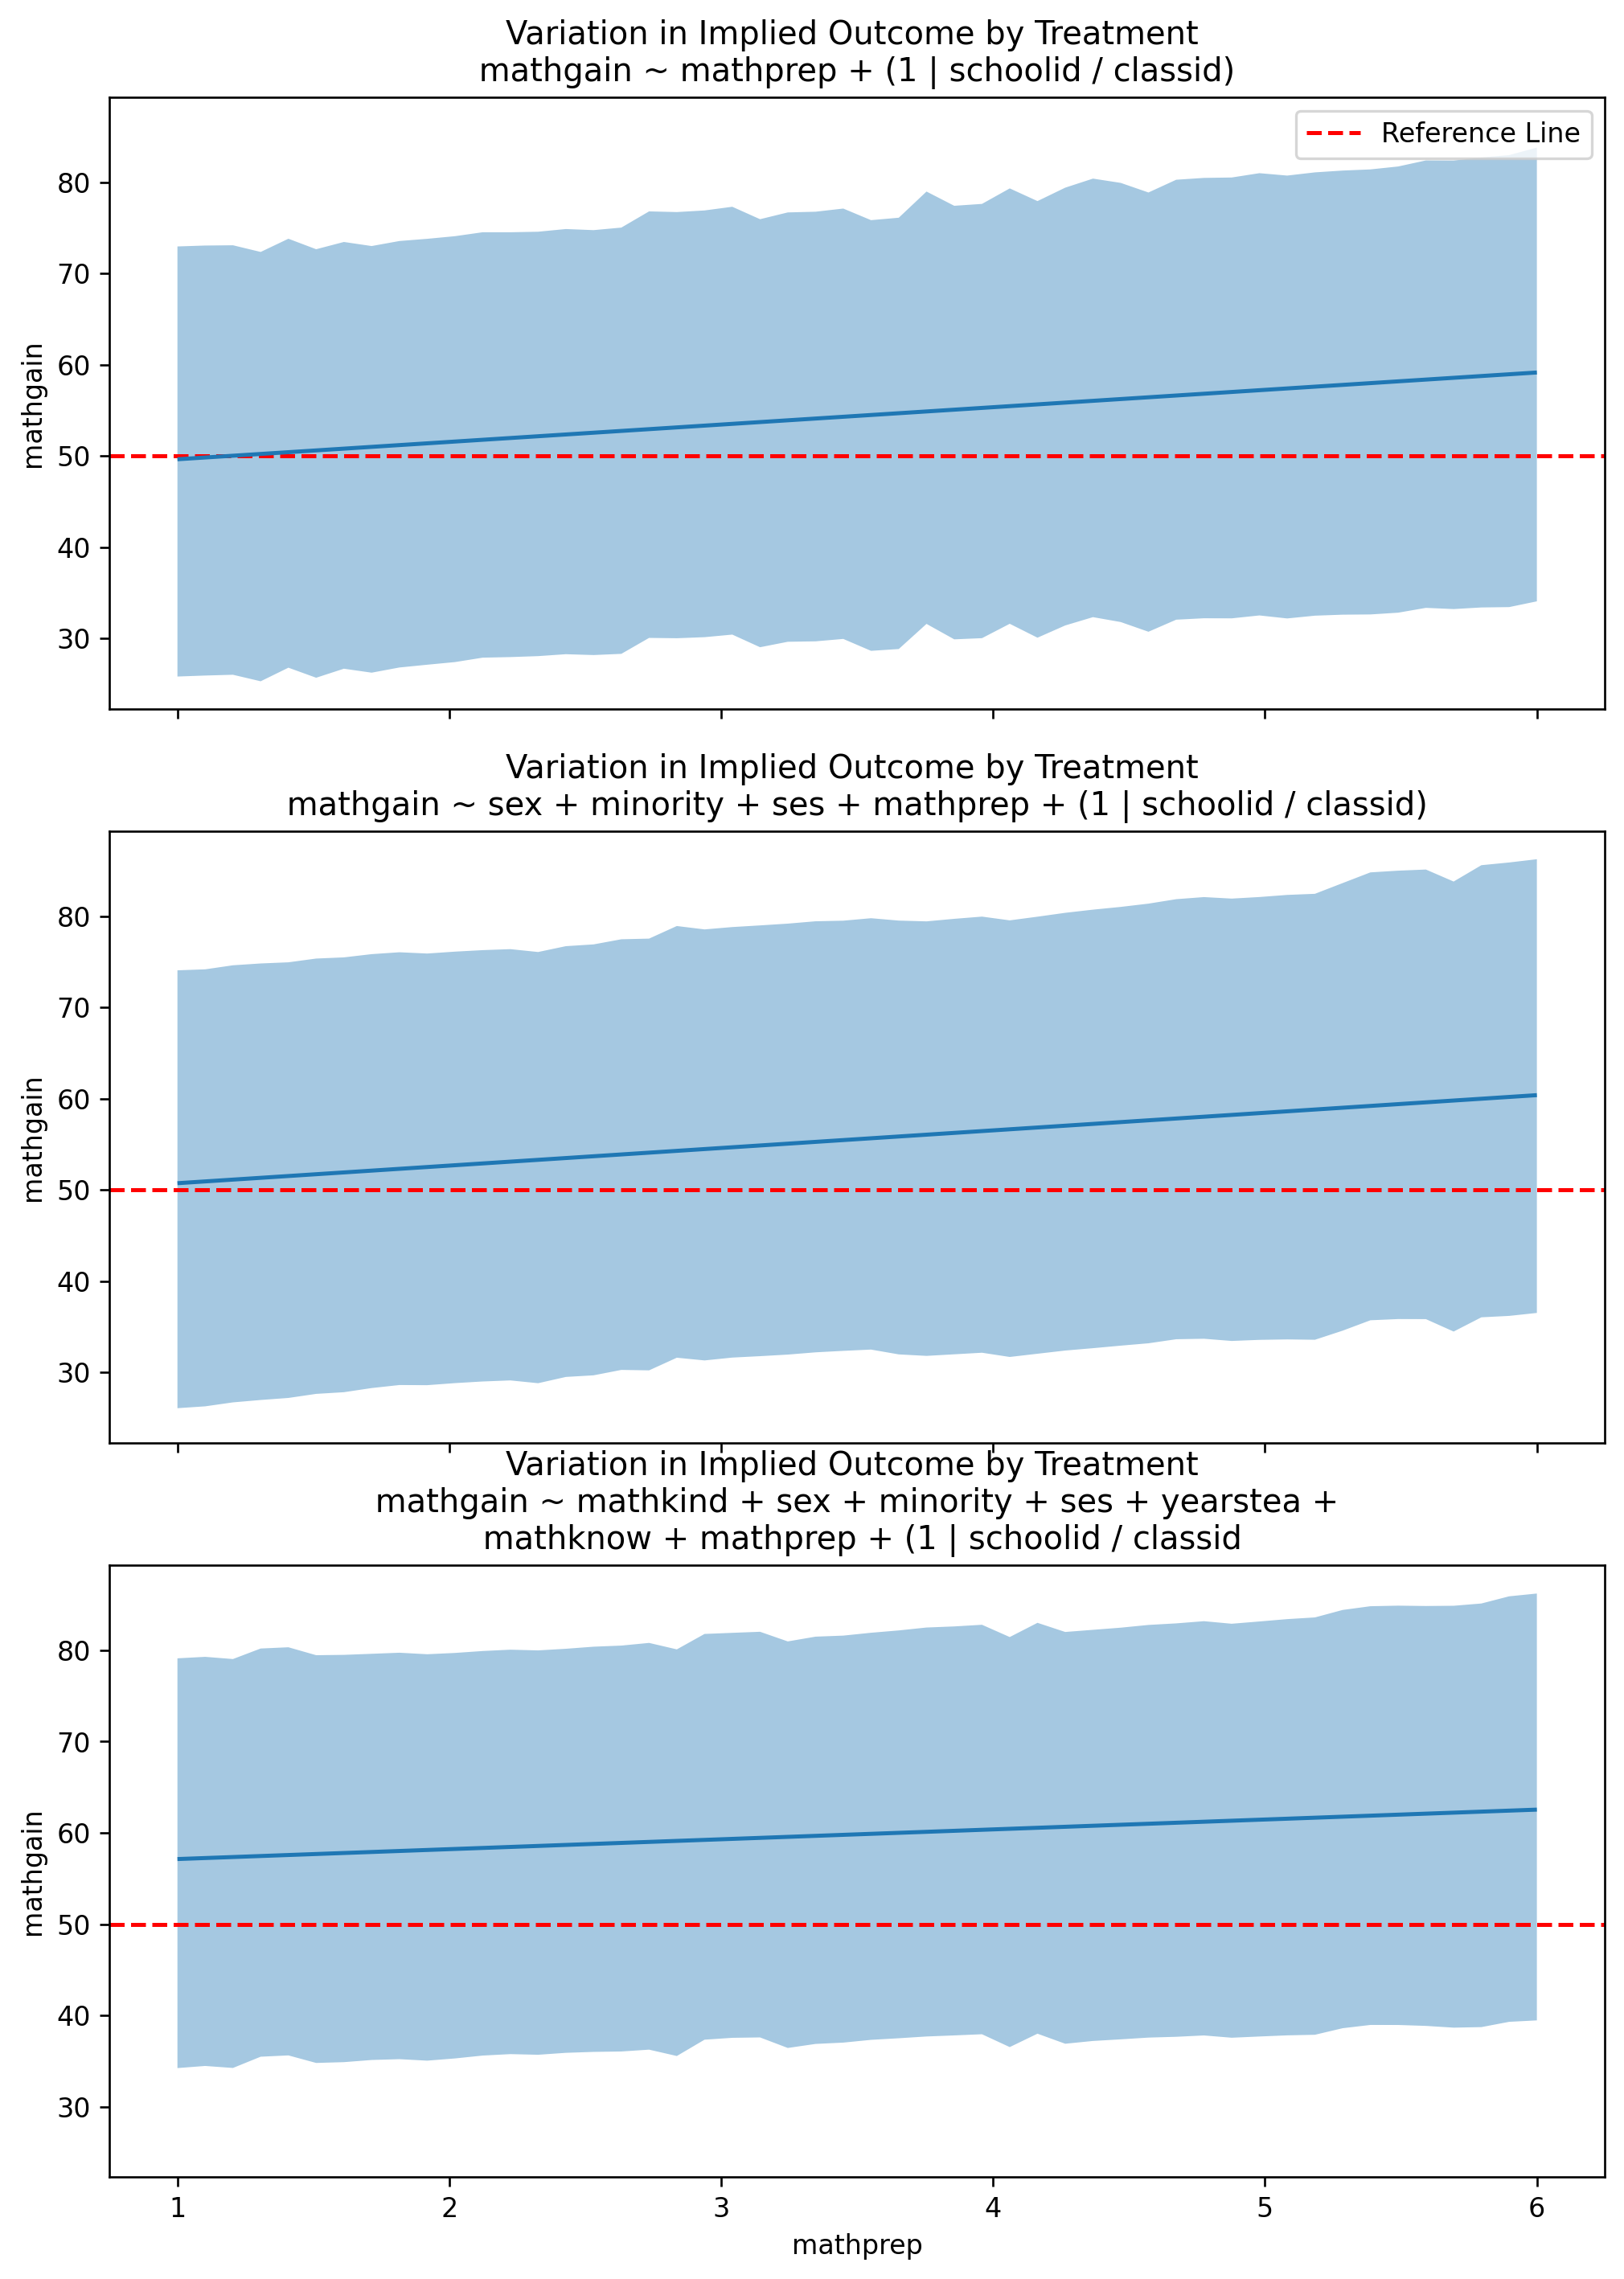

In [36]:
#| code-fold: true
fig, axs = plt.subplots(3, 1, figsize=(10, 14), 
dpi=120, sharey=True, sharex=True)
axs = axs.flatten()
axs[0].axhline(50, color='red', label='Reference Line', 
linestyle='--')
axs[1].axhline(50, color='red', label='Reference Line', 
linestyle='--')
axs[2].axhline(50, color='red', label='Reference Line', 
linestyle='--')
bmb.interpret.plot_predictions(model, idata, "mathprep", ax=axs[0]);
bmb.interpret.plot_predictions(model_fixed, idata_fixed, "mathprep", ax=axs[1]);
bmb.interpret.plot_predictions(model_fixed_1, idata_fixed_1, "mathprep", ax=axs[2]);
axs[0].set_title("Variation in Implied Outcome by Treatment \n mathgain ~ mathprep + (1 | schoolid / classid) ")
axs[1].set_title("Variation in Implied Outcome by Treatment \n mathgain ~ sex + minority + ses + mathprep + (1 | schoolid / classid) ")
axs[2].set_title("Variation in Implied Outcome by Treatment \n mathgain ~ mathkind + sex + minority + ses + yearstea + \n mathknow + mathprep + (1 | schoolid / classid")
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[0].legend();


As we can see here across all the different model specifications we see quite modest effects of treatment with very wide uncertainty. You might therefore be sceptical that teacher training has any real discernible impact on child outcomes? Maybe you believe other interventions are more important to fund? These kinds of questions determine policy. So misguided policy interventions on child-hood education can have radical consequences. It's, therefore, vital that we have robust and justifiable approaches and tooling for the analysis of these policy questions in the face of group level confounding. 

This last point is crucial - when model complexity balloons due extensive interaction effects, then we need efficient tools to interrogate the outcome level differences implied by the model choices. Your intuition and understanding of a process is keyed to the observable effects of that process. Your understanding of the internal mechanics of a model is likely less than your concrete expectations of observable behaviour. As such, credibility requires that we be able to assess models on the variation produced in the outcome variable rather merely on the parameters values. 

## Two Way Fixed Effects and Temporal Confounding

Difference in Differences designs are the overworked donkeys of social science. Many, many studies stand or fall by the assumptions baked into DiD designs. There are at least two aspects to these assumptions (i) the substantive commitments about the data generating process (e.g. parrallel trends) and (ii) the appropriateness of the functional form used to model (i). We will look first at a case where all the assumptions can be met, and then examine how things break-down under challenging staggered treatment regimes. 

### Event Studies and Change in Time

Event studies or dynamic treatment effects are an approach to measuring the gradual treatment effect as it evolves in time. We take this panel data set from the `pyfixest` package to demonstrate. 


In [37]:
url = "https://raw.githubusercontent.com/py-econometrics/pyfixest/master/pyfixest/did/data/df_het.csv"
df_het = pd.read_csv(url)
df_het.head()

unit  state    group   unit_fe     g  year   year_fe  treat  rel_year  \
0     1     33  Group 2  7.043016  2010  1990  0.066159  False     -20.0   
1     1     33  Group 2  7.043016  2010  1991 -0.030980  False     -19.0   
2     1     33  Group 2  7.043016  2010  1992 -0.119607  False     -18.0   
3     1     33  Group 2  7.043016  2010  1993  0.126321  False     -17.0   
4     1     33  Group 2  7.043016  2010  1994 -0.106921  False     -16.0   

   rel_year_binned     error  te  te_dynamic   dep_var  
0               -6 -0.086466   0         0.0  7.022709  
1               -6  0.766593   0         0.0  7.778628  
2               -6  1.512968   0         0.0  8.436377  
3               -6  0.021870   0         0.0  7.191207  
4               -6 -0.017603   0         0.0  6.918492

Panel data of this kind of structure is difficult to intuit unless visualised. The key structures on which this DiD estimator works are the averages across state and time. We depict these here. Note how we define a causal contrast as the difference between the treated and control groups averages over time. In particular our estimator has to account for the fact that we have a "dynamic" control group. As each cohort is treated our treatment group expands and the causal contrast of interest is differently defined. To gain a view of the time-evolution of treatment we want to marginalise over the specifc cohorts and extract a view of the how the effects evolve after the introduction of the treatment in expectation. 


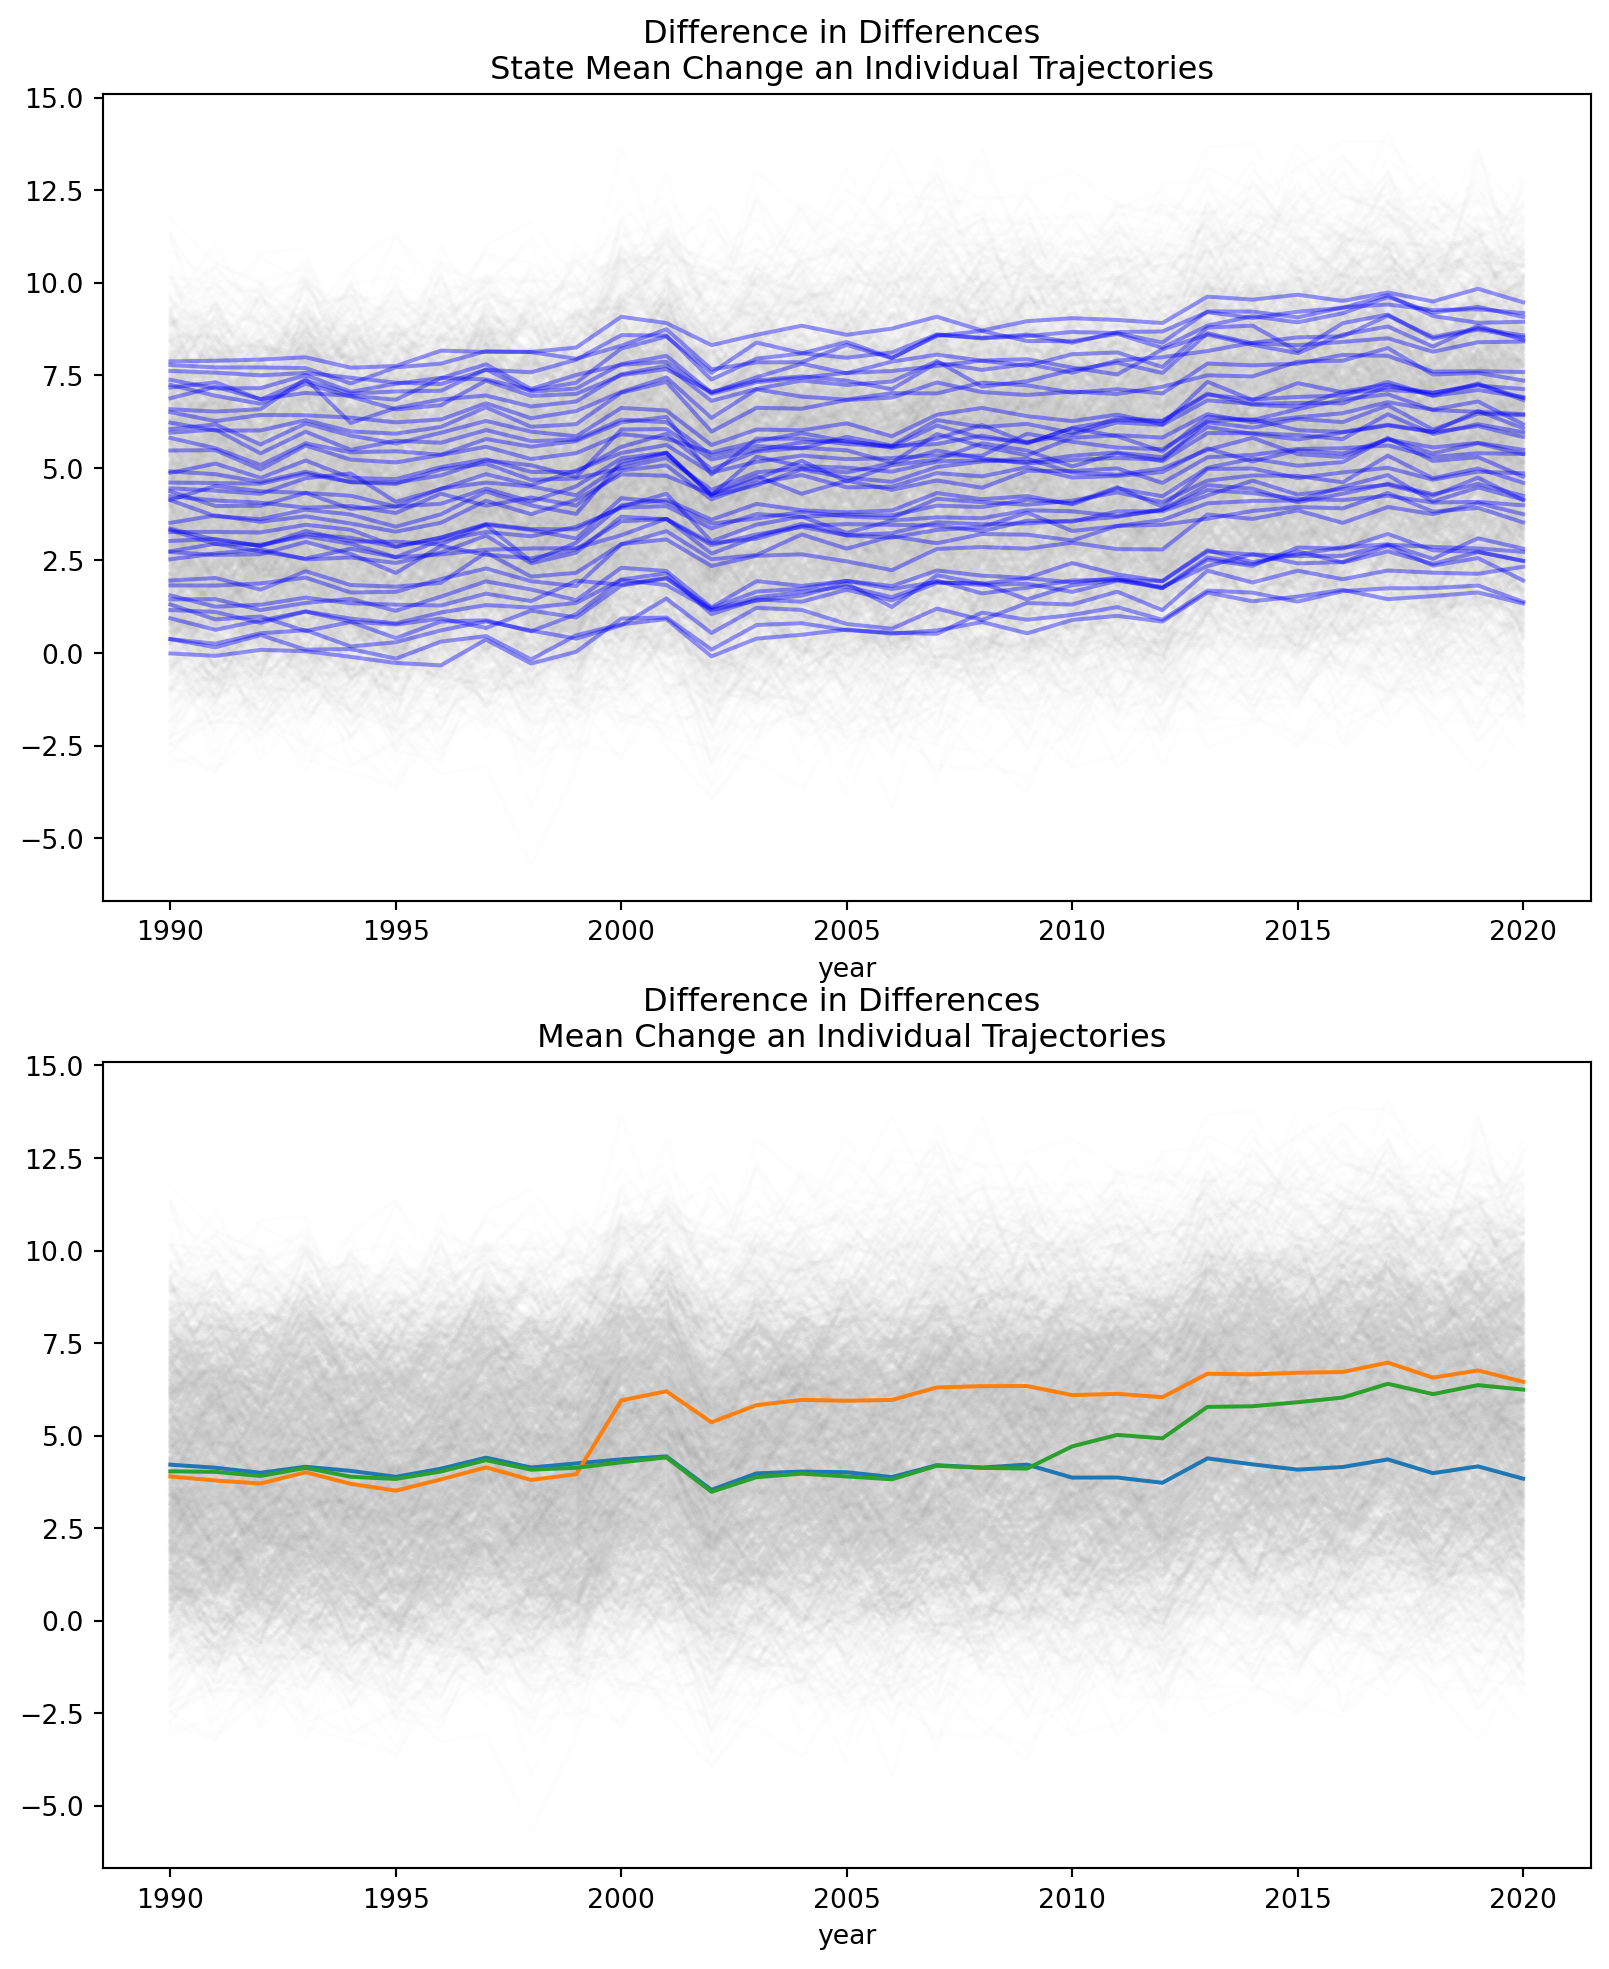

In [38]:
#| code-fold: true
#| 
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs = axs.flatten()
for u in df_het['unit'].unique():
    temp = df_het[df_het['unit']==u]
    axs[0].plot(temp['year'], temp['dep_var'], color='grey', alpha=0.01)
    axs[1].plot(temp['year'], temp['dep_var'], color='grey', alpha=0.01)
df_het.groupby(['year', 'state'])[['dep_var']].mean().reset_index().pivot(index='year', columns='state', values='dep_var').plot(ax=axs[0], legend=False, color='blue', 
alpha=0.4)

df_het.groupby(['year', 'g'])[['dep_var']].mean().reset_index().pivot(index='year', columns='g', values='dep_var').plot(ax=axs[1], legend=False)

axs[0].set_title("Difference in Differences \n State Mean Change an Individual Trajectories")
axs[1].set_title("Difference in Differences \n Mean Change an Individual Trajectories");

Note how the blue line represents a cohort that never undergoes a treatment and is maintained as a coherent control group throughout the sequence even though we have two other cohorts. This ensures we have a constant contrast case allowing us to identify the causal estimand of interest. It's also worth calling out that we have heterogenous patterns in the treatment effects across the cohorts i.e. the the intensity of the treatment effect differs across the cohorts. We'll apply the vanilla TWFE estimator. 

### TWFE in `pyfixest`

A natural question is to wonder how the treatment effect evolves over time? How does policy shift behaviours? Is it initially impactful converging to a quick plateau or a slowly building pattern of consistent growth?


In [39]:
fit_twfe_event = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year ",
    df_het,
    vcov={"CRV1": "state"},
)

fit_twfe_event.tidy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimate  Std. Error  \
Coefficient                                                              
C(rel_year, contr.treatment(base=-1.0))[T.-20.0] -0.099445    0.081699   
C(rel_year, contr.treatment(base=-1.0))[T.-19.0]  0.000624    0.083213   
C(rel_year, contr.treatment(base=-1.0))[T.-18.0]  0.004125    0.089719   
C(rel_year, contr.treatment(base=-1.0))[T.-17.0]  0.021899    0.085686   
C(rel_year, contr.treatment(base=-1.0))[T.-16.0] -0.036933    0.096921   
C(rel_year, contr.treatment(base=-1.0))[T.-15.0]  0.069578    0.081289   
C(rel_year, contr.treatment(base=-1.0))[T.-14.0]  0.037734    0.086618   
C(rel_year, contr.treatment(base=-1.0))[T.-13.0]  0.061779    0.083362   
C(rel_year, contr.treatment(base=-1.0))[T.-12.0]  0.089913    0.084900   
C(rel_year, contr.treatment(base=-1.0))[T.-11.0]  0.000982    0.079104   
C(rel_year, contr.treatment(base=-1.0))[T.-10.0] -0.113033    0.064922   
C(rel_year, contr.treatment(base=-1.0))[T.-9.0]  -0.069225    0.057046   
C(rel_year, contr.treatment(base=-1.0))[T.-8.0]  -0.061290    0.060362   
C(rel_year, contr.treatment(base=-1.0))[T.-7.0]  -0.002022    0.064602   
C(rel_year, contr.treatment(base=-1.0))[T.-6.0]  -0.055810    0.064674   
C(rel_year, contr.treatment(base=-1.0))[T.-5.0]  -0.065009    0.064810   
C(rel_year, contr.treatment(base=-1.0))[T.-4.0]  -0.009850    0.053098   
C(rel_year, contr.treatment(base=-1.0))[T.-3.0]   0.046338    0.062950   
C(rel_year, contr.treatment(base=-1.0))[T.-2.0]   0.015947    0.065442   
C(rel_year, contr.treatment(base=-1.0))[T.0.0]    1.406404    0.055641   
C(rel_year, contr.treatment(base=-1.0))[T.1.0]    1.660552    0.065033   
C(rel_year, contr.treatment(base=-1.0))[T.2.0]    1.728790    0.056793   
C(rel_year, contr.treatment(base=-1.0))[T.3.0]    1.854839    0.058315   
C(rel_year, contr.treatment(base=-1.0))[T.4.0]    1.958676    0.071144   
C(rel_year, contr.treatment(base=-1.0))[T.5.0]    2.082161    0.063855   
C(rel_year, contr.treatment(base=-1.0))[T.6.0]    2.191062    0.068510   
C(rel_year, contr.treatment(base=-1.0))[T.7.0]    2.279073    0.075014   
C(rel_year, contr.treatment(base=-1.0))[T.8.0]    2.364593    0.058598   
C(rel_year, contr.treatment(base=-1.0))[T.9.0]    2.372163    0.056560   
C(rel_year, contr.treatment(base=-1.0))[T.10.0]   2.649271    0.056177   
C(rel_year, contr.treatment(base=-1.0))[T.11.0]   2.753591    0.075526   
C(rel_year, contr.treatment(base=-1.0))[T.12.0]   2.813935    0.079320   
C(rel_year, contr.treatment(base=-1.0))[T.13.0]   2.756070    0.078368   
C(rel_year, contr.treatment(base=-1.0))[T.14.0]   2.863427    0.098389   
C(rel_year, contr.treatment(base=-1.0))[T.15.0]   2.986652    0.093309   
C(rel_year, contr.treatment(base=-1.0))[T.16.0]   2.963032    0.085427   
C(rel_year, contr.treatment(base=-1.0))[T.17.0]   2.972596    0.092390   
C(rel_year, contr.treatment(base=-1.0))[T.18.0]   2.935051    0.094126   
C(rel_year, contr.treatment(base=-1.0))[T.19.0]   2.918707    0.084193   
C(rel_year, contr.treatment(base=-1.0))[T.20.0]   2.979701    0.087777   
C(rel_year, contr.treatment(base=-1.0))[T.inf]    0.128053    0.078513   

                                                    t value  Pr(>|t|)  \
Coefficient                                                             
C(rel_year, contr.treatment(base=-1.0))[T.-20.0]  -1.217202  0.230842   
C(rel_year, contr.treatment(base=-1.0))[T.-19.0]   0.007493  0.994060   
C(rel_year, contr.treatment(base=-1.0))[T.-18.0]   0.045974  0.963565   
C(rel_year, contr.treatment(base=-1.0))[T.-17.0]   0.255573  0.799624   
C(rel_year, contr.treatment(base=-1.0))[T.-16.0]  -0.381067  0.705221   
C(rel_year, contr.treatment(base=-1.0))[T.-15.0]   0.855936  0.397262   
C(rel_year, contr.treatment(base=-1.0))[T.-14.0]   0.435641  0.665499   
C(rel_year, contr.treatment(base=-1.0))[T.-13.0]   0.741098  0.463073   
C(rel_year, contr.treatment(base=-1.0))[T.-12.0]   1.059044  0.296095   
C(rel_year, contr.treatment(base=-1.0))[T.-11.0]   0.012417  0.9

The model specification defines indicator variables for the relative years before and after the penultimate year before treatment is applied, it then  incorporates the fixed effects for state and year. The coefficient values ascribed the the relative year indicators are used to plot the event-study trajectories. This is a two-way fixed effects estimation routine where the fixed effects for state and year indicators absorb the variance due to those groupings. It is often estimated using a de-meaning technique which we will demonstrate below.


In [40]:
figsize = [1200, 600]
fit_twfe_event.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
).show()


We can also aim to marginalise over the details of the temporal trajectories by defining the similar estimation routine on the individuals and their treatment indicator.


In [41]:
fit_twfe = pf.feols(
    "dep_var ~ i(treat) | unit + year",
    df_het,
    vcov={"CRV1": "state"},
)

fit_twfe.tidy()


Estimate  Std. Error    t value  Pr(>|t|)      2.5%  \
Coefficient                                                             
C(treat)[T.True]   1.98254    0.019331  102.55618       0.0  1.943439   

                     97.5%  
Coefficient                 
C(treat)[T.True]  2.021642

### De-meaning and TWFEs

We've seen above that the fixed-effect estimators in these DiD designs involve a lot of indicator variables. These are largely not the focus on the question at hand but are used exlusively to absorb the noise that takes away from our understanding of the treatment effect. We can achieve similar results with less parameters required if we "de-mean" the focus variables by the group averages of the control factors of `state` and `year` or `unit`. This operation makes for more efficient TWFE estimation routines is [provably](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3906345) a variety of mundlak regression as shown by Woolridge 2021. 

We implement the de-meaning technique and show "equivalence by python" as follows:

In [42]:
def demean(df, col_to_demean, group):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby(group)[col_to_demean].transform("mean")
                                        )})


def apply_demeaning(df_het, by=['state', 'year'], event=True):
    if event: 
        d = pd.get_dummies(df_het['rel_year']).drop(-1, axis=1) 
        d.columns = ['rel_year_' +str(c).replace('-', 'minus_') for c in d.columns]
    else:
        d = df_het[['treat']]
    d[by[0]] = df_het[by[0]]
    d[by[1]] = df_het[by[1]]
    for col in d.columns: 
        if col in by:
            pass
        else: 
            for c in by:
                d = demean(d, col, c)
    d = d.drop(by, axis=1)
    d['dep_var'] = df_het['dep_var']
    return d
## Demean the relative years features for event studies
d_event = apply_demeaning(df_het, by=['state', 'year'], event=True)

## Demean the treatment indicator for ATT estimation
d = apply_demeaning(df_het, by=['unit', 'year'], event=False)

d_event.head()

rel_year_minus_20.0  rel_year_minus_19.0  rel_year_minus_18.0  \
0             0.651694            -0.002973            -0.002973   
1            -0.002973             0.651694            -0.002973   
2            -0.002973            -0.002973             0.651694   
3            -0.002973            -0.002973            -0.002973   
4            -0.002973            -0.002973            -0.002973   

   rel_year_minus_17.0  rel_year_minus_16.0  rel_year_minus_15.0  \
0            -0.002973            -0.002973            -0.002973   
1            -0.002973            -0.002973            -0.002973   
2            -0.002973            -0.002973            -0.002973   
3             0.651694            -0.002973            -0.002973   
4            -0.002973             0.651694            -0.002973   

   rel_year_minus_14.0  rel_year_minus_13.0  rel_year_minus_12.0  \
0            -0.002973            -0.002973            -0.002973   
1            -0.002973            -0.002973            -0.002973   
2            -0.002973            -0.002973            -0.002973   
3            -0.002973            -0.002973            -0.002973   
4            -0.002973            -0.002973            -0.002973   

   rel_year_minus_11.0  ...  rel_year_13.0  rel_year_14.0  rel_year_15.0  \
0            -0.002973  ...       0.000734       0.000734       0.000734   
1            -0.002973  ...       0.000734       0.000734       0.000734   
2            -0.002973  ...       0.000734       0.000734       0.000734   
3            -0.002973  ...       0.000734       0.000734       0.000734   
4            -0.002973  ...       0.000734       0.000734       0.000734   

   rel_year_16.0  rel_year_17.0  rel_year_18.0  rel_year_19.0  rel_year_20.0  \
0       0.000734       0.000734       0.000734       0.000734       0.000734   
1       0.000734       0.000734       0.000734       0.000734       0.000734   
2       0.000734       0.000734       0.000734       0.000734       0.000734   
3       0.000734       0.000734       0.000734       0.000734       0.000734   
4       0.000734       0.000734       0.000734       0.000734       0.000734   

   rel_year_inf   dep_var  
0      -0.28125  7.022709  
1      -0.28125  7.778628  
2      -0.28125  8.436377  
3      -0.28125  7.191207  
4      -0.28125  6.918492  

[5 rows x 42 columns]

We now have a data set with 42 columns focused on the treatment structures, but implicitly controls for the variation due to state and time. We'll see below that this representation of the data will correctly estimate the treatment effects. 

### Event Study and De-Meaning
Now we'll use the de-meaned data structure above to estimate an event study using `Bambi`. 


In [43]:
#| output: false
#| 
x_cols = ' + '.join([c for c in d_event.columns if c != 'dep_var'])
model_twfe_event = bmb.Model(f"dep_var ~ + {x_cols}", d_event)
idata_twfe_event = model_twfe_event.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)


Compiling...


Compilation time = 0:00:02.301950


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:52.605358


Transforming variables...


Transformation time = 0:00:00.243047


Computing Log Likelihood...


Log Likelihood time = 0:00:00.929996


In [44]:
model_twfe_event

       Formula: dep_var ~ + rel_year_minus_20.0 + rel_year_minus_19.0 + rel_year_minus_18.0 + rel_year_minus_17.0 + rel_year_minus_16.0 + rel_year_minus_15.0 + rel_year_minus_14.0 + rel_year_minus_13.0 + rel_year_minus_12.0 + rel_year_minus_11.0 + rel_year_minus_10.0 + rel_year_minus_9.0 + rel_year_minus_8.0 + rel_year_minus_7.0 + rel_year_minus_6.0 + rel_year_minus_5.0 + rel_year_minus_4.0 + rel_year_minus_3.0 + rel_year_minus_2.0 + rel_year_0.0 + rel_year_1.0 + rel_year_2.0 + rel_year_3.0 + rel_year_4.0 + rel_year_5.0 + rel_year_6.0 + rel_year_7.0 + rel_year_8.0 + rel_year_9.0 + rel_year_10.0 + rel_year_11.0 + rel_year_12.0 + rel_year_13.0 + rel_year_14.0 + rel_year_15.0 + rel_year_16.0 + rel_year_17.0 + rel_year_18.0 + rel_year_19.0 + rel_year_20.0 + rel_year_inf
        Family: gaussian
          Link: mu = identity
  Observations: 46500
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.7062, sigma: 7.1549)
            rel_year_minus

We can then plot the event-study and observe a similar pattern to the one observed with `pyfixest`. 


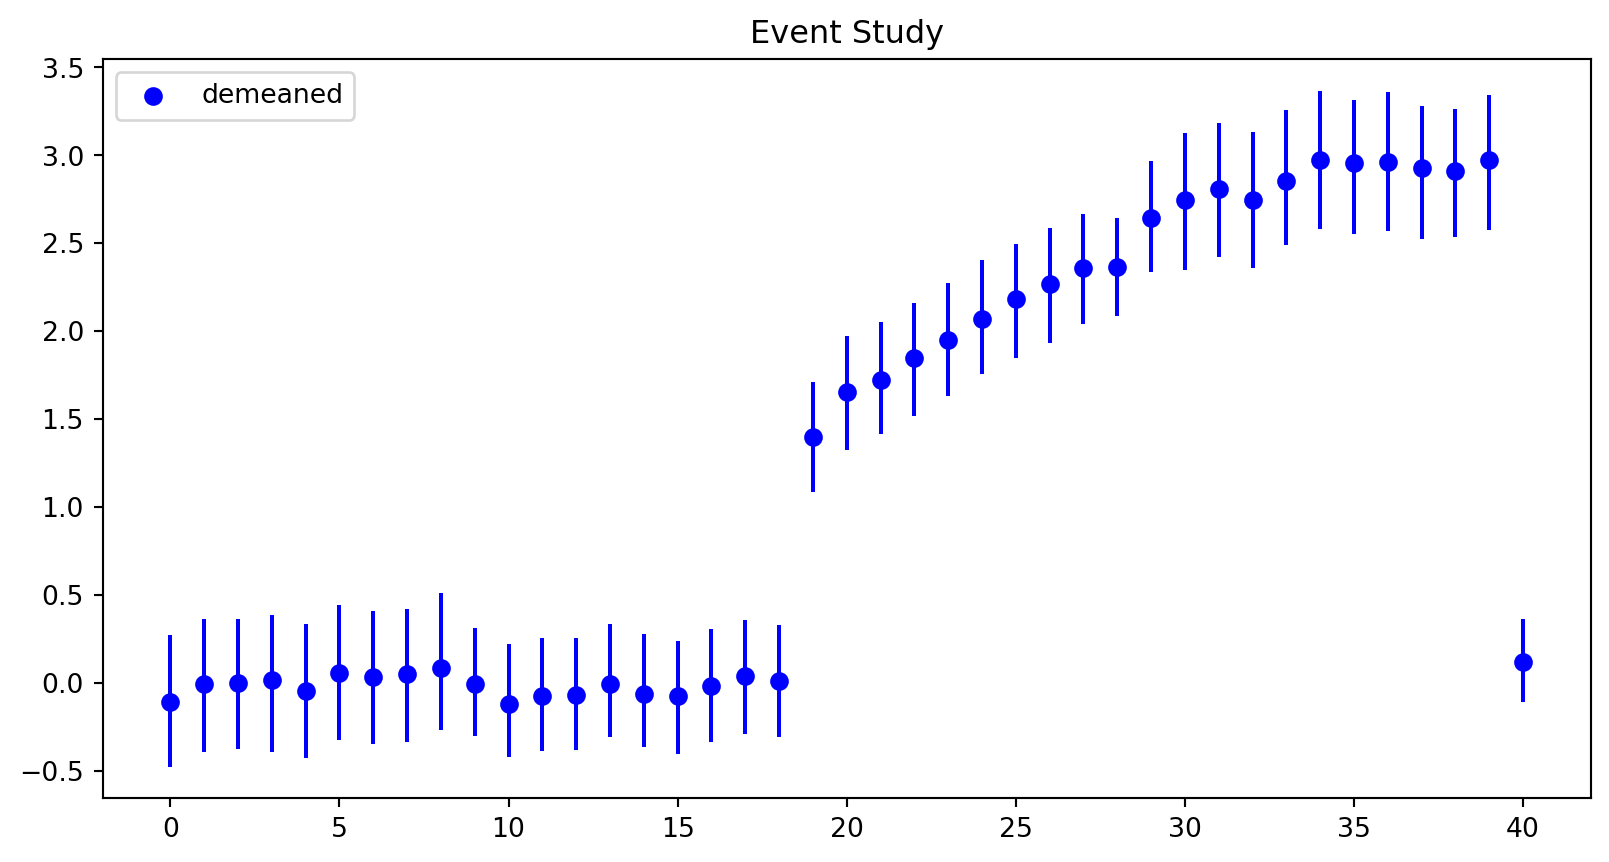

In [45]:
def plot_event_study(idata, ax, color='blue', model='demeaned'):
    summary_df = az.summary(idata)
    cols = [i for i in summary_df.index if 'rel' in i]
    summary_df = summary_df[summary_df.index.isin(cols)]
    x = range(len(summary_df))
    ax.scatter(x, summary_df['mean'], label=model, color=color)
    ax.plot([x, x], [summary_df['hdi_3%'],summary_df['hdi_97%']],   color=color)
    ax.set_title("Event Study")
    return ax

fig, ax = plt.subplots(figsize=(10, 5))
plot_event_study(idata_twfe_event, ax)
ax.legend();

Similarly, we can de-mean the simple treatment indicator using the group means and marginalise over time periods to find a single treatment effect estimate. 


In [46]:
#| output: false

model_twfe_trt_demean = bmb.Model(f"dep_var ~ treat", d)
idata_twfe_trt_demean = model_twfe_trt_demean.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)


Compiling...


Compilation time = 0:00:00.415458


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.503866


Transforming variables...


Transformation time = 0:00:00.032999


Computing Log Likelihood...


Log Likelihood time = 0:00:00.610087


In [47]:
az.summary(idata_twfe_trt_demean)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept      4.706  0.013   4.681    4.730      0.000    0.000    3169.0   
treat          1.982  0.048   1.894    2.072      0.001    0.001    3138.0   
dep_var_sigma  2.811  0.009   2.793    2.829      0.000    0.000    5252.0   

               ess_tail  r_hat  
Intercept        2717.0    1.0  
treat            2742.0    1.0  
dep_var_sigma    2977.0    1.0

Which again accords with the reported values from `pyfixest`. This is equivalent to using a Mundlak device as we can see below: 

### TWFE by Mundlak Device

Woolridge recounts that the TWFE is equivalent to a Mundlak regression where: 

> [The Mundlak devices] $\bar{X_{i}}$ and $\bar{X_{t}}$ effectively act as sufficient statistics in accounting for any unit-specific heterogeneity and time-specific heterogeneity that
is correlated with $X_{it}$. Rather than having to include (N − 1) + (T − 1) control variables, it suffices to include 2K control variables, $\bar{X_{i}}$, $\bar{X_{t}}$ - _Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators_

We will see an example of this equivalence here.

In [48]:
#| output: false

df_het['unit_mean'] = df_het.groupby('unit')['treat'].transform(np.mean)
df_het['time_mean'] = df_het.groupby('year')['treat'].transform(np.mean)

model_twfe_trt = bmb.Model(f"dep_var ~ treat", df_het)
idata_twfe_trt = model_twfe_trt.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

model_twfe_trt_mundlak = bmb.Model(f"dep_var ~ treat + unit_mean + time_mean", df_het)
idata_twfe_trt_mundlak = model_twfe_trt_mundlak.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.413426


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.511498


Transforming variables...


Transformation time = 0:00:00.032997


Computing Log Likelihood...


Log Likelihood time = 0:00:02.553754


Compiling...


Compilation time = 0:00:00.544364


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.580908


Transforming variables...


Transformation time = 0:00:00.043428


Computing Log Likelihood...


Log Likelihood time = 0:00:01.495449


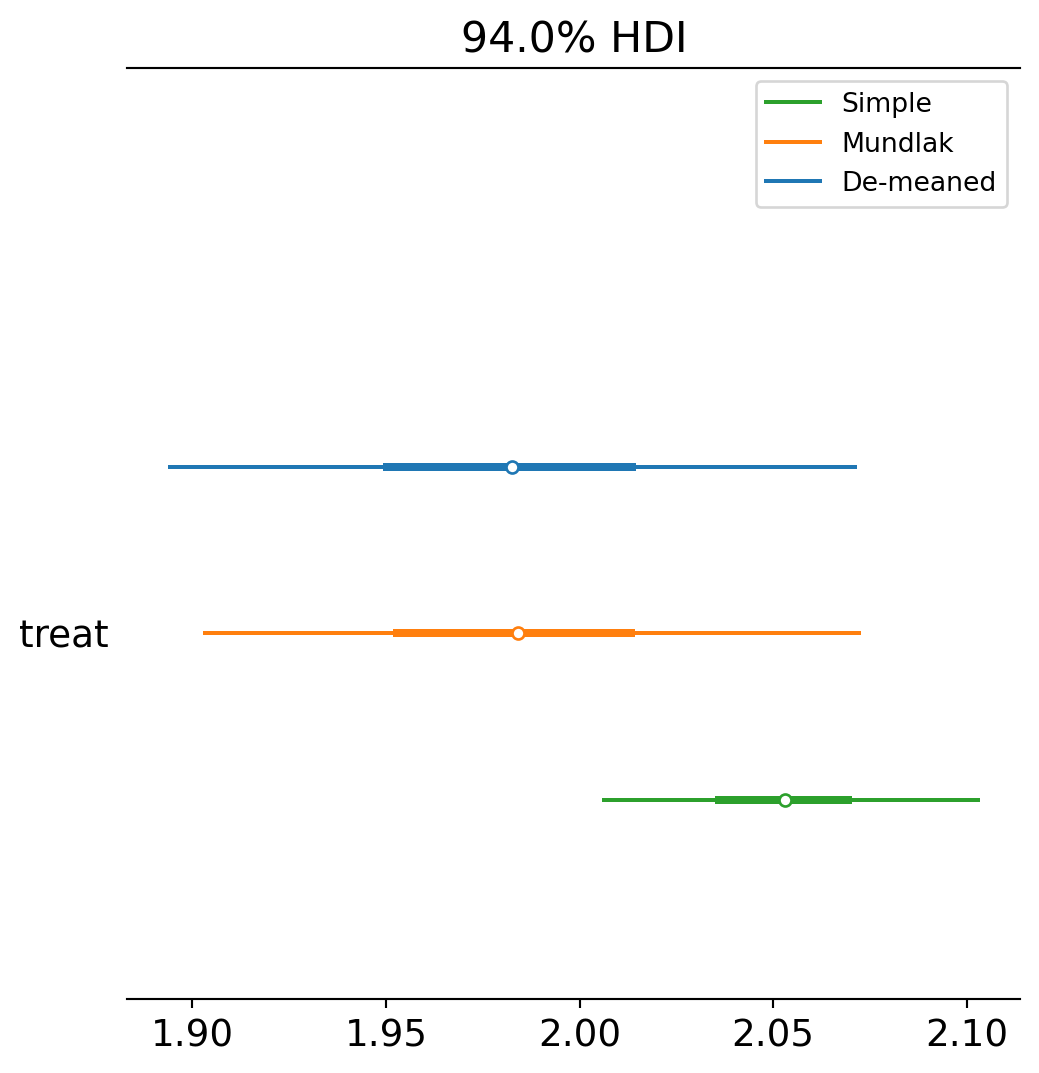

In [49]:
az.plot_forest([idata_twfe_trt_demean, idata_twfe_trt_mundlak, idata_twfe_trt], combined=True, var_names=['treat'], model_names=['De-meaned', 'Mundlak', 'Simple']);

The de-meaned TWFE estimator and the Mundlak specification result in identical estimates and differ from the naive estimate that fails to control group level confounds. The Mundlak specification is far easier to implement and offers altnerative ways to parameterise a model capable of adjusting for the group level confounding.

### Functional Form and Saturated Regression

The vanilla TWFE estimator _can_ successfully recover the treatment effects in DiD designs and facilitate event studies of the same. However, the details of the estimation matter because this functional form is not always robust. Here we'll see other options that can recover substantially the same inferences and may prove more robust as we'll see below. The key to each is to articulate enough structural features that allow the model to modify effects based on the suspected group level confounds. 


In [50]:
#| output: false

df_het['state_mean'] = df_het.groupby('state')['treat'].transform(np.mean)
df_het['time_mean'] = df_het.groupby('year')['treat'].transform(np.mean)
df_het['cohort_mean'] = df_het.groupby('group')['treat'].transform(np.mean)

model_twfe_event_1 = bmb.Model(f"dep_var ~ 1 + C(year) + state_mean + C(rel_year, Treatment(reference=-1)) ", df_het)
idata_twfe_event_1 = model_twfe_event_1.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


formula = """ dep_var ~ 1 + time_mean:state_mean + C(rel_year, Treatment(reference=-1))"""
twfe_model_ols = smf.ols(formula, data=df_het).fit()
twfe_model_ols.summary()
param_est = pd.DataFrame(twfe_model_ols.params, columns=['estimate']).iloc[1:-1]
param_est['index_number'] = list(range(len(param_est)))
temp = (param_est.reset_index()
)
param_est = temp[(~temp['index'].str.contains(':')) & (temp['index'].str.contains('rel'))]
param_est.reset_index(inplace=True)


model_twfe_event_2 = bmb.Model(f"dep_var ~ (1 | year) + state_mean + C(rel_year, Treatment(reference=-1)) ", df_het)
idata_twfe_event_2 = model_twfe_event_2.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


Compiling...


Compilation time = 0:00:00.748018


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:58.899610


Transforming variables...


Transformation time = 0:00:00.072807


Computing Log Likelihood...


Log Likelihood time = 0:00:01.789686


Compiling...


Compilation time = 0:00:00.843528


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:41.697995


Transforming variables...


Transformation time = 0:00:00.086241


Computing Log Likelihood...


Log Likelihood time = 0:00:01.722434


Having estimated the various alternatives model specifications we compare each against our baseline de-meaned event-study.


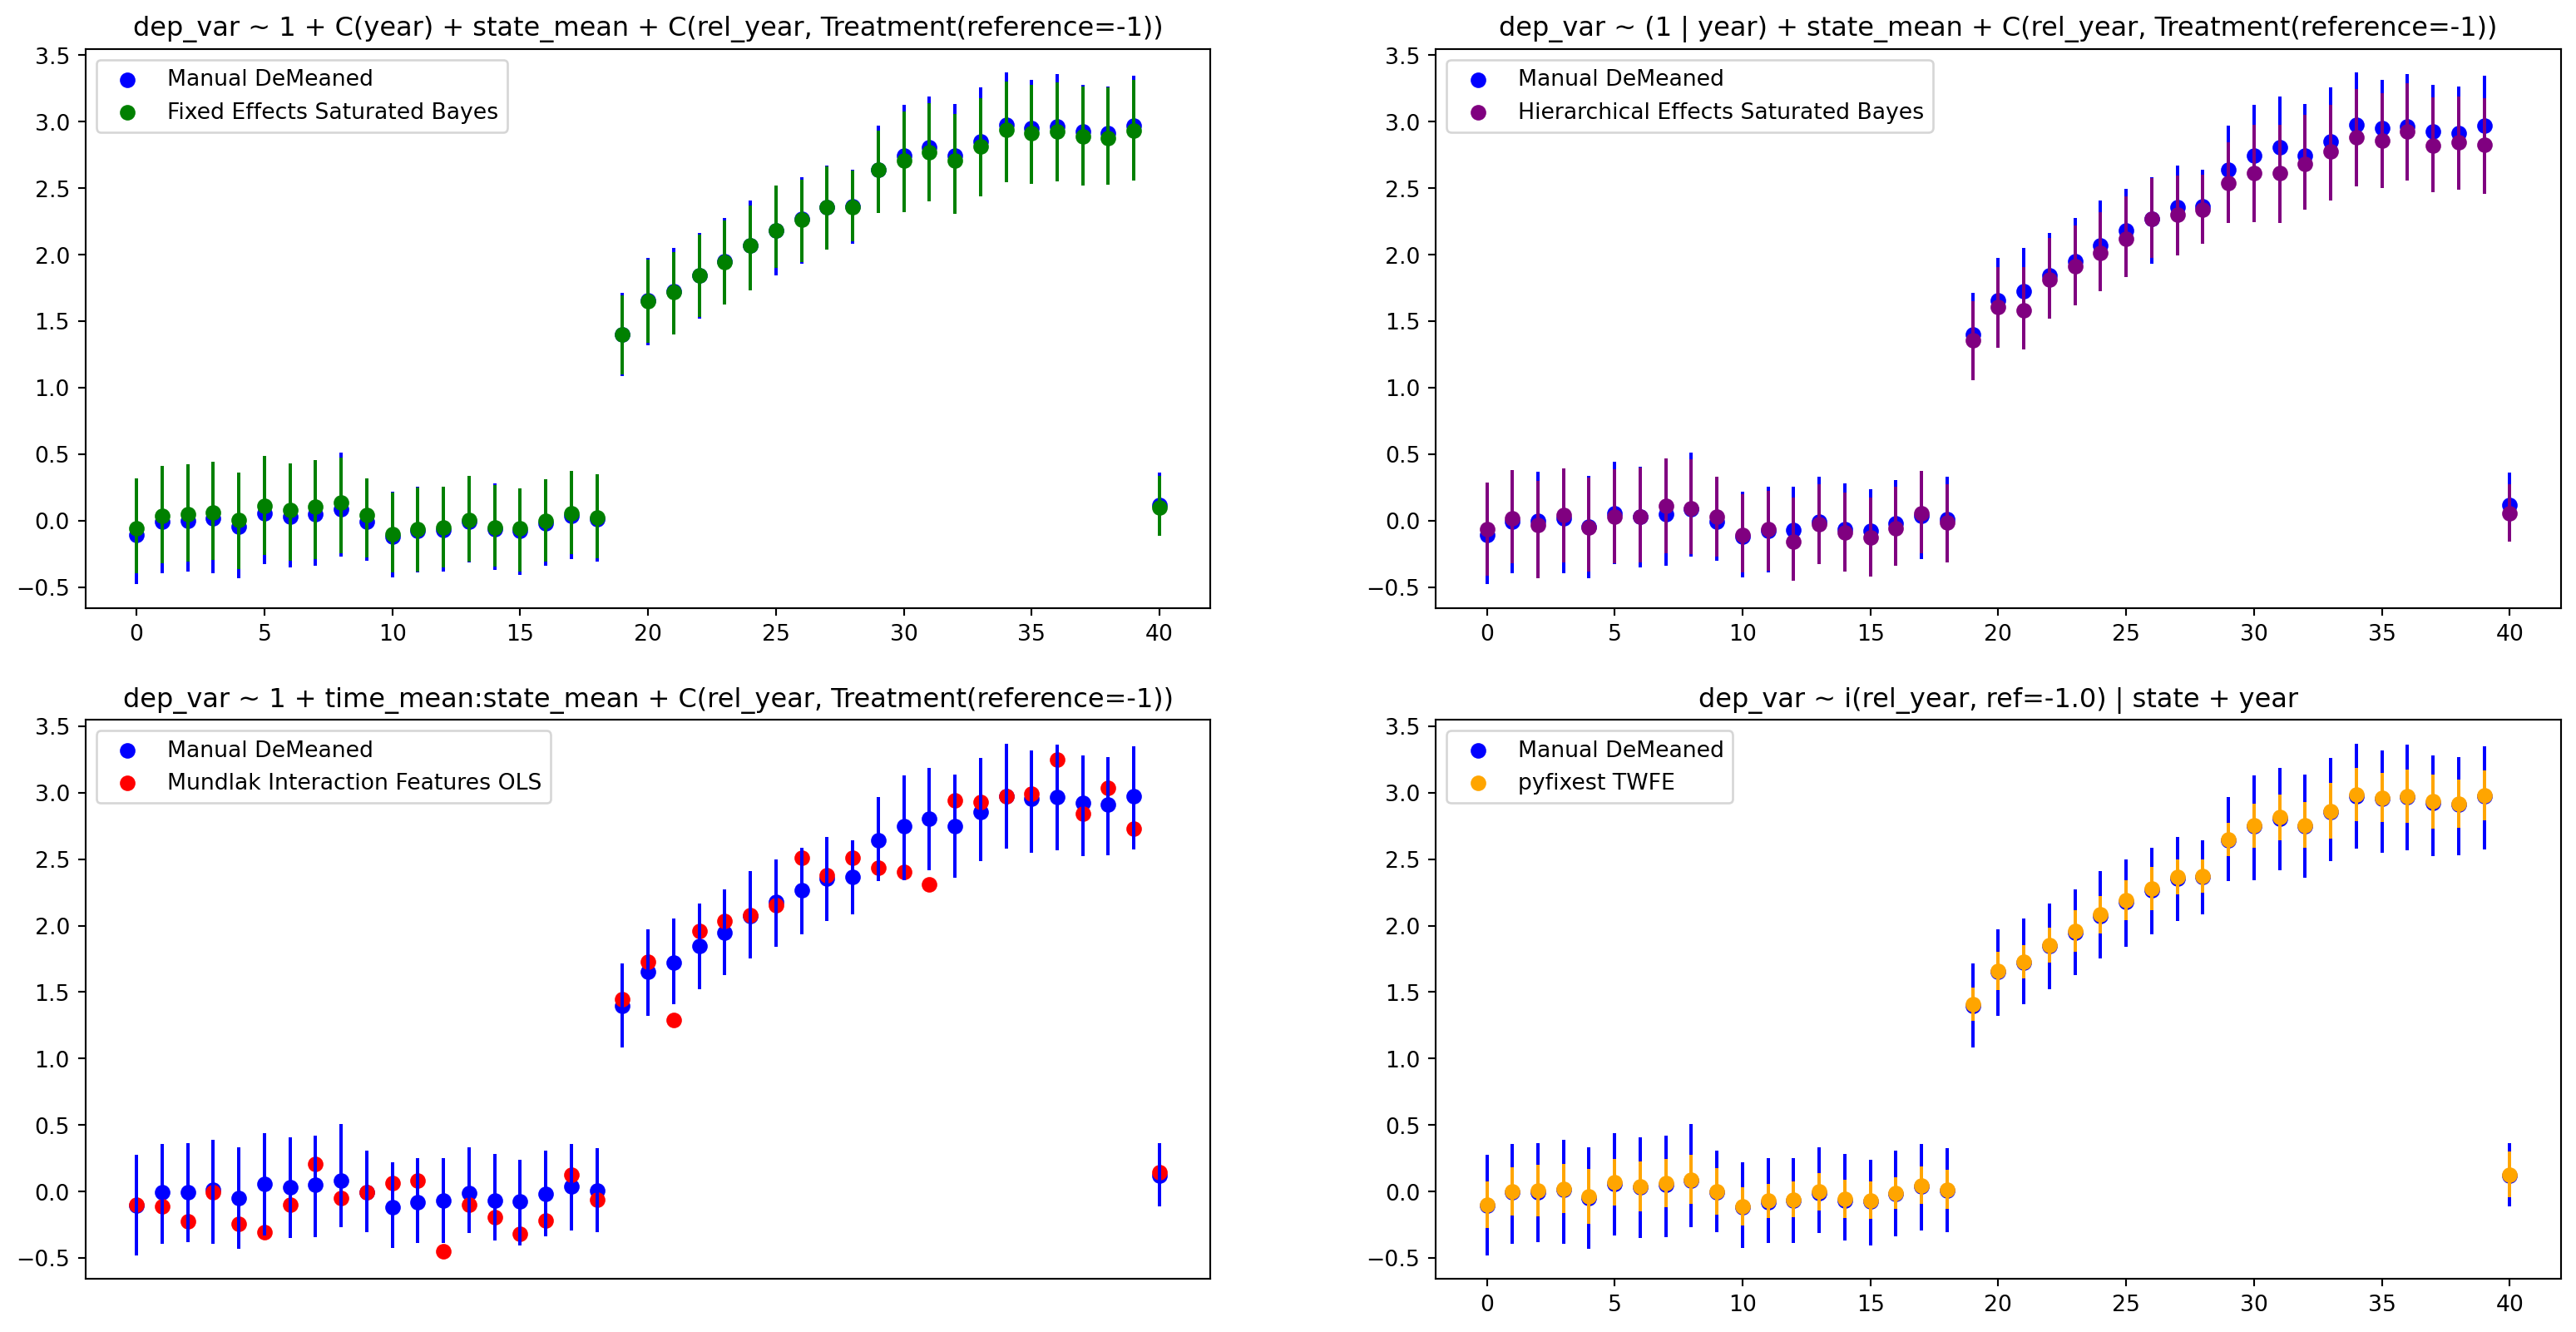

In [51]:
#| code-fold: true
#| 
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
plot_event_study(idata_twfe_event, axs[0], model='Manual DeMeaned')
plot_event_study(idata_twfe_event, axs[1], model='Manual DeMeaned')
plot_event_study(idata_twfe_event, axs[2], model='Manual DeMeaned')
plot_event_study(idata_twfe_event, axs[3], model='Manual DeMeaned')
plot_event_study(idata_twfe_event_1, axs[0], color='green', model='Fixed Effects Saturated Bayes')
plot_event_study(idata_twfe_event_2, axs[1], color='purple', model='Hierarchical Effects Saturated Bayes')
axs[2].scatter(param_est['index'], param_est['estimate'], color='red', label='Mundlak Interaction Features OLS')
tidy = fit_twfe_event.tidy()
xs = range(len(tidy))
tidy.reset_index(inplace=True)
axs[3].scatter(xs, tidy['Estimate'], color='orange', label='pyfixest TWFE')
axs[3].plot([xs, xs], [tidy['2.5%'],tidy['97.5%']], color='orange')
axs[2].set_xticks([])
axs[0].set_title("dep_var ~ 1 + C(year) + state_mean + C(rel_year, Treatment(reference=-1))")
axs[1].set_title("dep_var ~ (1 | year) + state_mean + C(rel_year, Treatment(reference=-1))")
axs[2].set_title("dep_var ~ 1 + time_mean:state_mean + C(rel_year, Treatment(reference=-1))")
axs[3].set_title("dep_var ~ i(rel_year, ref=-1.0) | state + year")
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend();

`

This suggests that there are a variety of functional forms even just using regression specifications that seek to control from different types of group level confounding. In this example data most of the functional forms that seek to control for time and state level effects seem to converge in their answers. We will now switch to an example where the vanilla TWFE breaks down. 

## Issues with TWFE and Richly Parameterised Linear Models

We draw on the example from Pedro Sant'Anna [here](https://psantanna.com/posts/twfe) where it is demonstrated that the vanilla TWFE estimator breaks down under various conditions. These conditions are often related to staggered roll out of a treatment and thereby induces dynamic changes in the treatment group over time. Appropriate inference needs to carefully control for the interaction effects due to staggered treatment. 

Let's generate some data. 

In [52]:
true_mu = 1

def make_data(nobs = 1000, nstates = 40):
    ids = list(range(nobs))
    states = np.random.choice(range(nstates), size=nobs, replace=True)
    unit = pd.DataFrame({'unit': ids, 
                        'state': states, 
                        'unit_fe': np.random.normal(states/5, 1, size=nobs),
                        'mu': true_mu})
    
    year = pd.DataFrame({'year': pd.date_range('1980-01-01', '2010-01-01', freq='y'), 
    'year_fe': np.random.normal(0, 1, 30) })
    year['year'] = year['year'].dt.year

    treat_taus = pd.DataFrame({'state': np.random.choice(range(nstates), size=nstates, replace=False),
    'cohort_year': np.sort([1986, 1992, 1998, 2004]*10)
    })

    cross_join = pd.DataFrame([row for row in product(range(nobs), year['year'].unique())], columns =['unit', 'year'])
    cross_join = cross_join.merge(unit, how='left', left_on='unit', 
    right_on='unit')
    cross_join = cross_join.merge(year, how='left', left_on='year', 
    right_on='year')
    cross_join = cross_join.merge(treat_taus, how='left', left_on='state', right_on='state')
    cross_join = cross_join.assign(
        error = np.random.normal(0, 1, len(cross_join)),
        treat = lambda x: np.where(x['year'] >= x['cohort_year'], 1, 0)
    )
    cross_join = cross_join.assign(tau = np.where(cross_join['treat'] == 1, cross_join['mu'], 0), 
    ).assign(year_fe = lambda x: x['year_fe'] + 0.1*(x['year']-x['cohort_year']))

    cross_join['tau_cum'] = cross_join.groupby('unit')['tau'].transform(np.cumsum)
    cross_join = cross_join.assign(dep_var = lambda x: 2010-x['cohort_year'] + 
    x['unit_fe'] + x['year_fe'] + x['tau_cum'] + x['error'])
    cross_join['rel_year'] =  cross_join['year'] - cross_join['cohort_year']

    
    return cross_join

sim_df = make_data(500, 40)
sim_df.head()

unit  year  state   unit_fe  mu   year_fe  cohort_year     error  treat  \
0     0  1980     12  2.770007   1 -1.443538         1998 -0.883541      0   
1     0  1981     12  2.770007   1 -3.140326         1998  1.044140      0   
2     0  1982     12  2.770007   1 -2.430673         1998  0.276021      0   
3     0  1983     12  2.770007   1 -4.253994         1998  0.181049      0   
4     0  1984     12  2.770007   1 -3.347429         1998 -2.104055      0   

   tau  tau_cum    dep_var  rel_year  
0    0        0  12.442927       -18  
1    0        0  12.673821       -17  
2    0        0  12.615355       -16  
3    0        0  10.697061       -15  
4    0        0   9.318523       -14

We can now plot the staggered nature of the imagined treatment regime. 


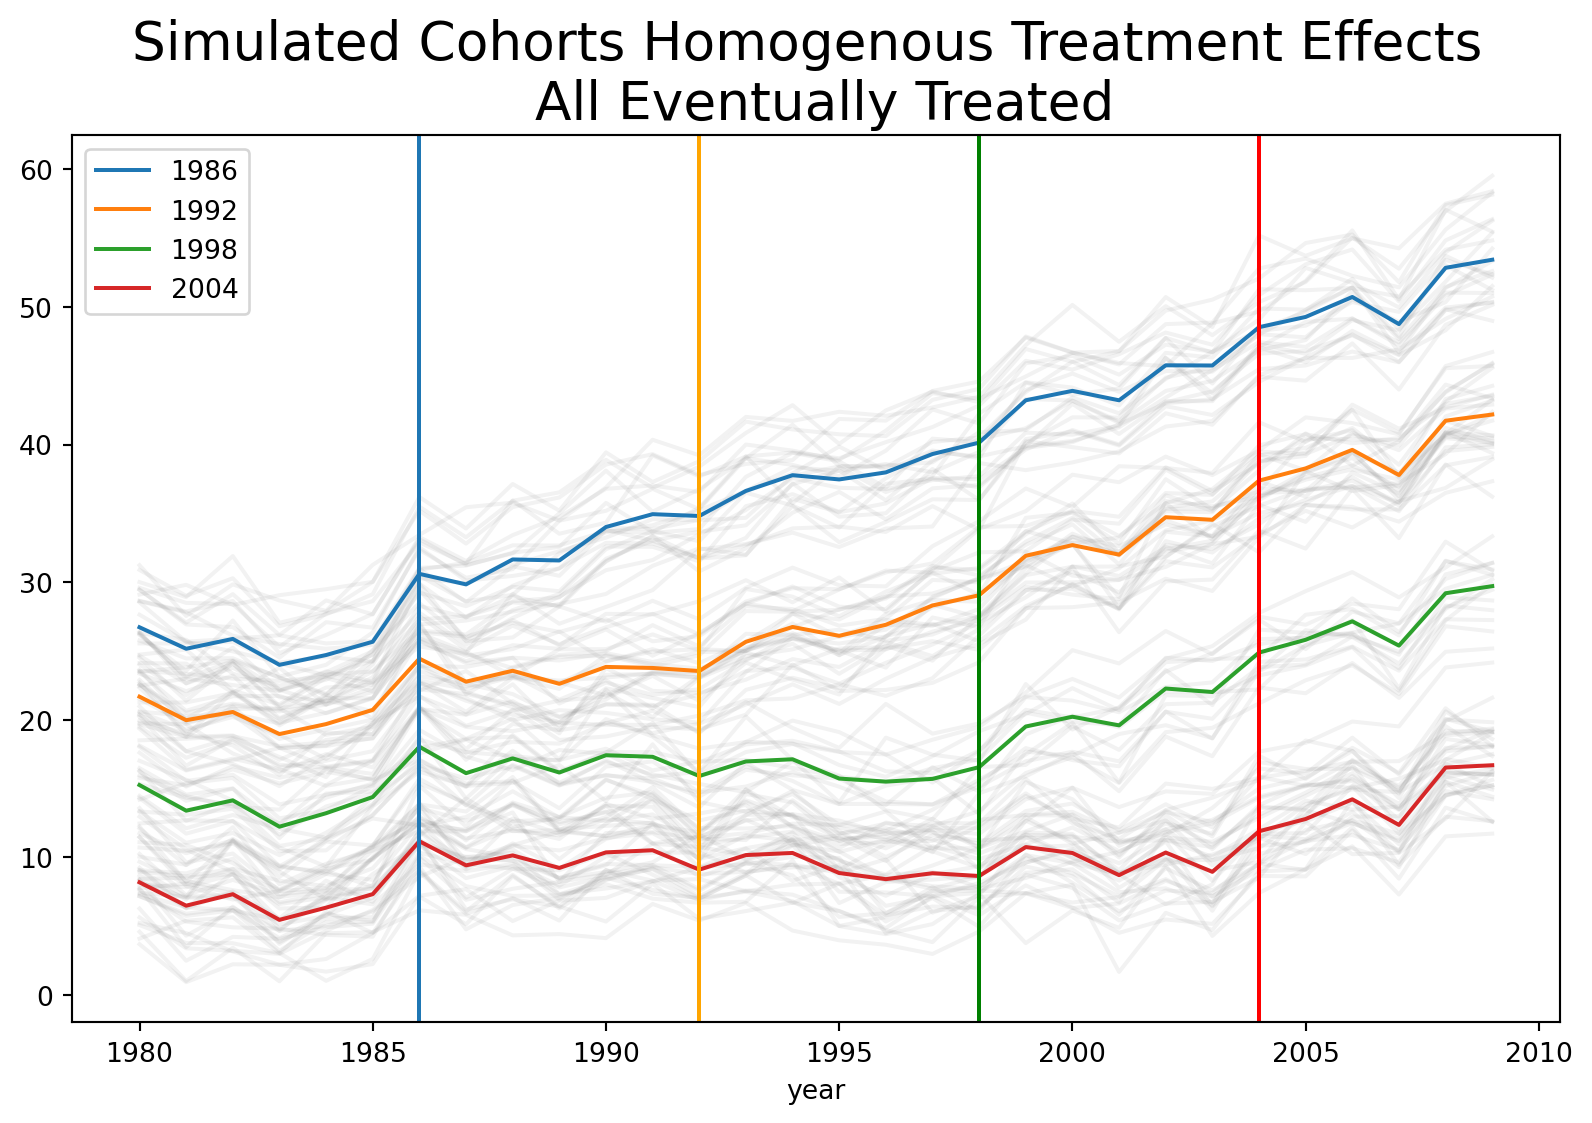

In [53]:
#| code-fold: true

fig, ax = plt.subplots(figsize=(10, 6))

for unit in sim_df['unit'].unique()[0:100]:
    temp = sim_df[sim_df['unit'] == unit]
    ax.plot(temp['year'], temp['dep_var'], alpha=0.1, color='grey')

sim_df.groupby(['cohort_year', 'year'])[['dep_var']].mean().reset_index().pivot(index='year', columns='cohort_year', values='dep_var').plot(ax=ax)
ax.axvline(1986)
ax.axvline(1992, color='orange')
ax.axvline(1998, color='green')
ax.axvline(2004, color='red')
ax.set_title("Simulated Cohorts Homogenous Treatment Effects \n All Eventually Treated", fontsize=20)
ax.legend()

This data will present problems for the vanilla TWFE estimator in part because we can see how each cohort receives a treatment and there are periods in the data when no group is in the "control". We can see how this plays out with de-meaning TWFE strategy. 


In [54]:
fit_twfe = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    sim_df,
    vcov={"CRV1": "state"},
)


figsize = [1200, 400]
fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
).show()

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.18]', 'C(rel_year, contr.treatment(base=-1.0))[T.19]', 'C(rel_year, contr.treatment(base=-1.0))[T.20]', 'C(rel_year, contr.treatment(base=-1.0))[T.21]', 'C(rel_year, contr.treatment(base=-1.0))[T.22]', 'C(rel_year, contr.treatment(base=-1.0))[T.23]'].
            The variables are dropped from the model.
            
  warnings.warn(


This is not the expected pattern. For contrast, consider an alternative estimator.


In [55]:
fit_lpdid = lpdid(
    data=sim_df,
    yname="dep_var",
    gname="cohort_year",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-17,
    post_window=17,
    att=False,
)

fit_lpdid.iplot(
    coord_flip=False,
    title="Local-Projections-Estimator",
    figsize=figsize,
    yintercept=0,
    xintercept=18.5,
).show()

The initial TWFE estimate is frankly bizarre and utterly skewed. Something dreadful has gone wrong under the hood. For contrast, we've included the Local Projections estimator from the `pyfixest` to show that we can recover the actual treatment effect under this event study with alternative strategies.
However, there is more machinary involved in the local-projections estimator. 

::: {.callout-warning}

Note there has been a large volume of literature diagnosing precisely how and where TWFE estimator breakdown. Goodman-Bacon's "_Difference-in-differences with variation in treatment timing_" in particular provides a decomposition of the causal estimand that can be recovered under varying treatment regimes. We won't cover this rich area of research here. But note that it's a lively area of research.
:::

Instead we want show how to use mundlak devices to recover more reasonable estimates. No fancy estimators, just more regressions. 

<img src="moreregression.png" width="500" height="300" />

Woolridge argues for this approach when he states that

> [T]hat there is nothing inherently wrong with TWFE, which is an estimation method. The problem with how TWFE is implemented in DiD settings is that it is applied to a restrictive model...
- _Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators_

We want to explore different ways of isolating the treatment effects under a variety of model specifications that controls for
time-constant treatment intensities, covariates, and interactions between them.

### Fitting a Variety of Models


In [56]:
#| output: false

sim_df['unit_mean'] = sim_df.groupby('unit')['treat'].transform(np.mean)

sim_df['state_mean'] = sim_df.groupby('state')['treat'].transform(np.mean)

sim_df['cohort_mean'] = sim_df.groupby('cohort_year')['treat'].transform(np.mean)

sim_df['time_mean'] = sim_df.groupby('year')['treat'].transform(np.mean)


model_twfe = bmb.Model(f"""dep_var ~ 1  + time_mean:state_mean + C(rel_year, Treatment(reference=-1))""", sim_df)

idata_twfe = model_twfe.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


model_twfe1 = bmb.Model(f"""dep_var ~ 1  + time_mean* state_mean + C(cohort_year) + C(rel_year, Treatment(reference=-1))""", sim_df)

idata_twfe1 = model_twfe1.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


model_twfe2 = bmb.Model(f"""dep_var ~ 1  + cohort_mean: state_mean + C(rel_year, Treatment(reference=-1))""", sim_df)

idata_twfe2 = model_twfe2.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

model_twfe3 = bmb.Model(f"""dep_var ~ (1| year)  + state_mean + C(rel_year, Treatment(reference=-1))""", sim_df)
idata_twfe3 = model_twfe3.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.577740


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:14.905015


Transforming variables...


Transformation time = 0:00:00.064634


Computing Log Likelihood...


Log Likelihood time = 0:00:00.533439


Compiling...


Compilation time = 0:00:00.722355


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:07:26.858572


Transforming variables...


Transformation time = 0:00:00.079281


Computing Log Likelihood...


Log Likelihood time = 0:00:00.635595


Compiling...


Compilation time = 0:00:00.537118


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:07.287274


Transforming variables...


Transformation time = 0:00:00.040894


Computing Log Likelihood...


Log Likelihood time = 0:00:00.624239


Compiling...


Compilation time = 0:00:01.153464


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:17.038411


Transforming variables...


Transformation time = 0:00:00.063545


Computing Log Likelihood...


Log Likelihood time = 0:00:00.719497


These latter models will recover the appropriate treatment effects with slight variations due to the adapted functional form. 


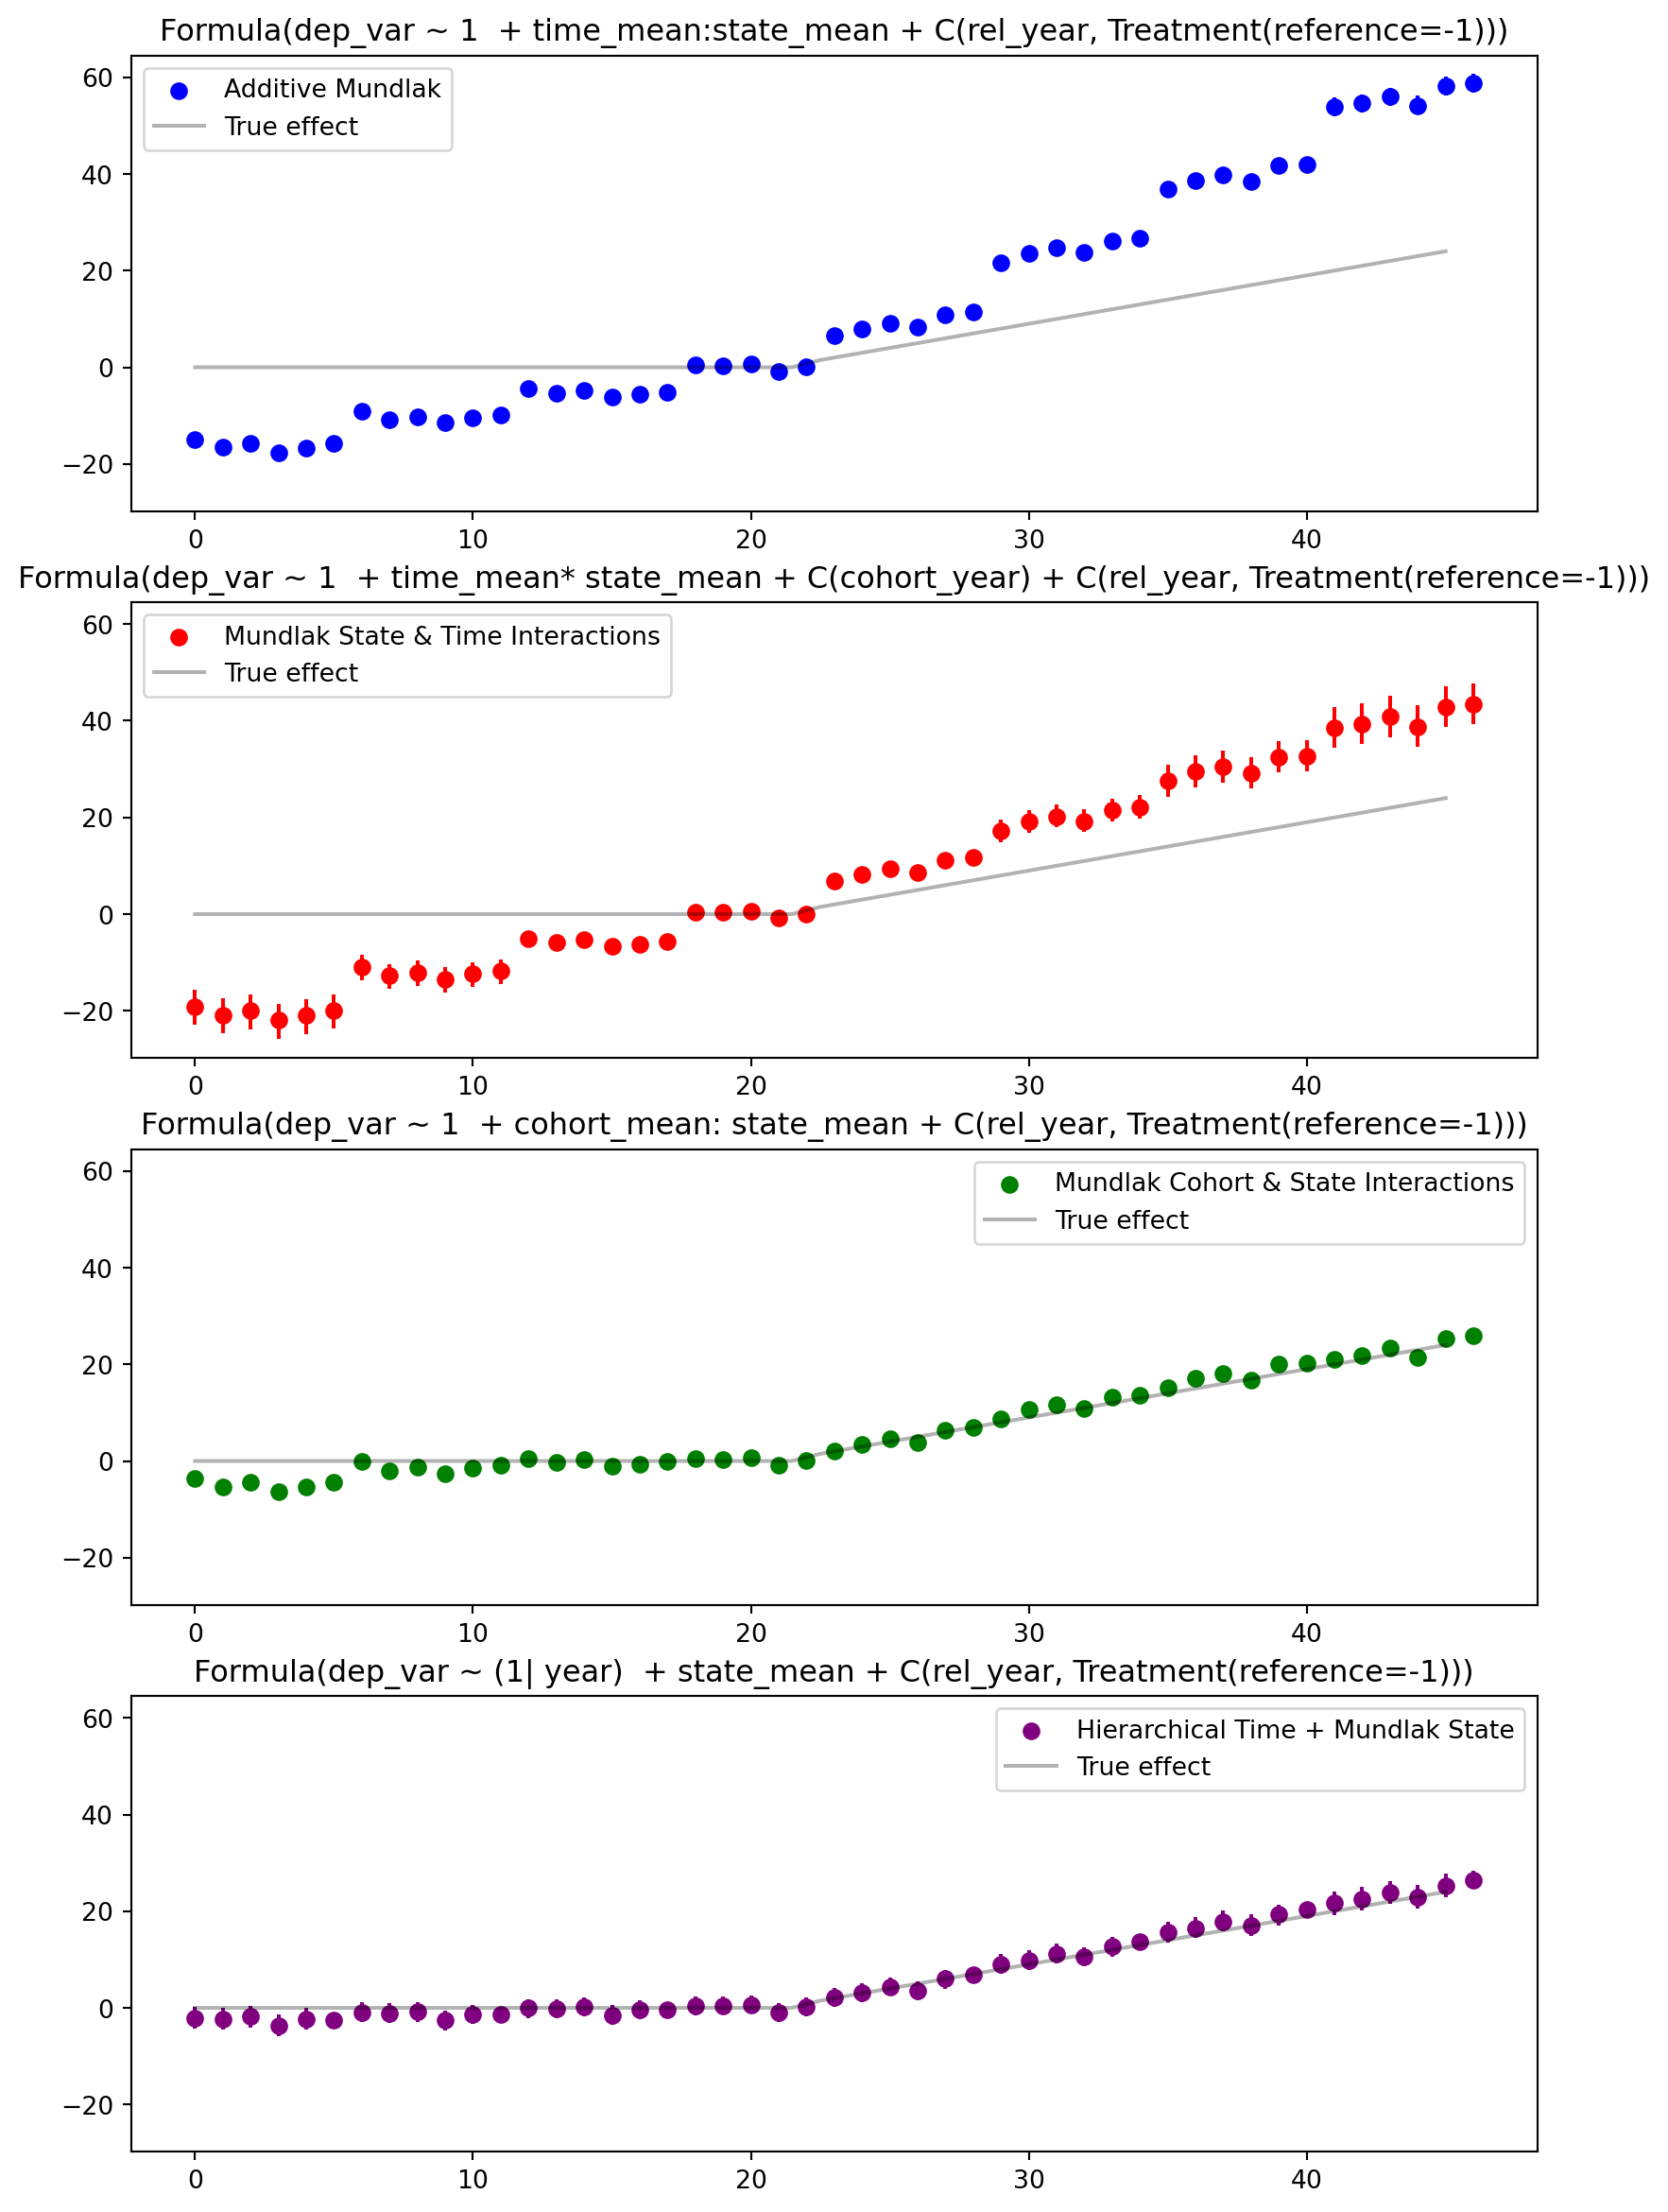

In [57]:
#| code-fold: true
#| 
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharey=True)
axs = axs.flatten()
plot_event_study(idata_twfe, ax=axs[0], model='Additive Mundlak')
plot_event_study(idata_twfe1, ax=axs[1], color='red', model='Mundlak State & Time Interactions')
plot_event_study(idata_twfe2, ax=axs[2], color='green', model='Mundlak Cohort & State Interactions')
plot_event_study(idata_twfe3, ax=axs[3], color='purple', model='Hierarchical Time + Mundlak State')
axs[0].set_title(str(model_twfe.formula))
axs[1].set_title(str(model_twfe1.formula))
axs[2].set_title(str(model_twfe2.formula))
axs[3].set_title(str(model_twfe3.formula))
xs = np.linspace(0, 45, 45)
xs_centered = xs - 22
true_effect = np.where(xs_centered <= 0, 0, (xs_centered +1))
axs[0].plot(xs, true_effect, color='k', alpha=0.3, label='True effect')
axs[1].plot(xs, true_effect, color='k', alpha=0.3, label='True effect')
axs[2].plot(xs, true_effect, color='k', alpha=0.3, 
label='True effect')
axs[3].plot(xs, true_effect, color='k', alpha=0.3,
label='True effect')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend();

Note how the naive mundlak approach also exhibits odd behaviour as we saw in the TWFE estimation routine above. Adding additional interactions and controlling for the staggered launch dates seems to help isolate the real pattern in the data. We've seen approximate success in a number of these richly parameterised versions of simple event study regressions. But the idiosyncracies of any one sample will contort and distort the estimates away from the true values. We might hope for more stability in expectation over repeated draws from this kind of data-generating process. Consier the following Bootstrapping estimation routine. 

### Evaluating Robustness of Functional Form


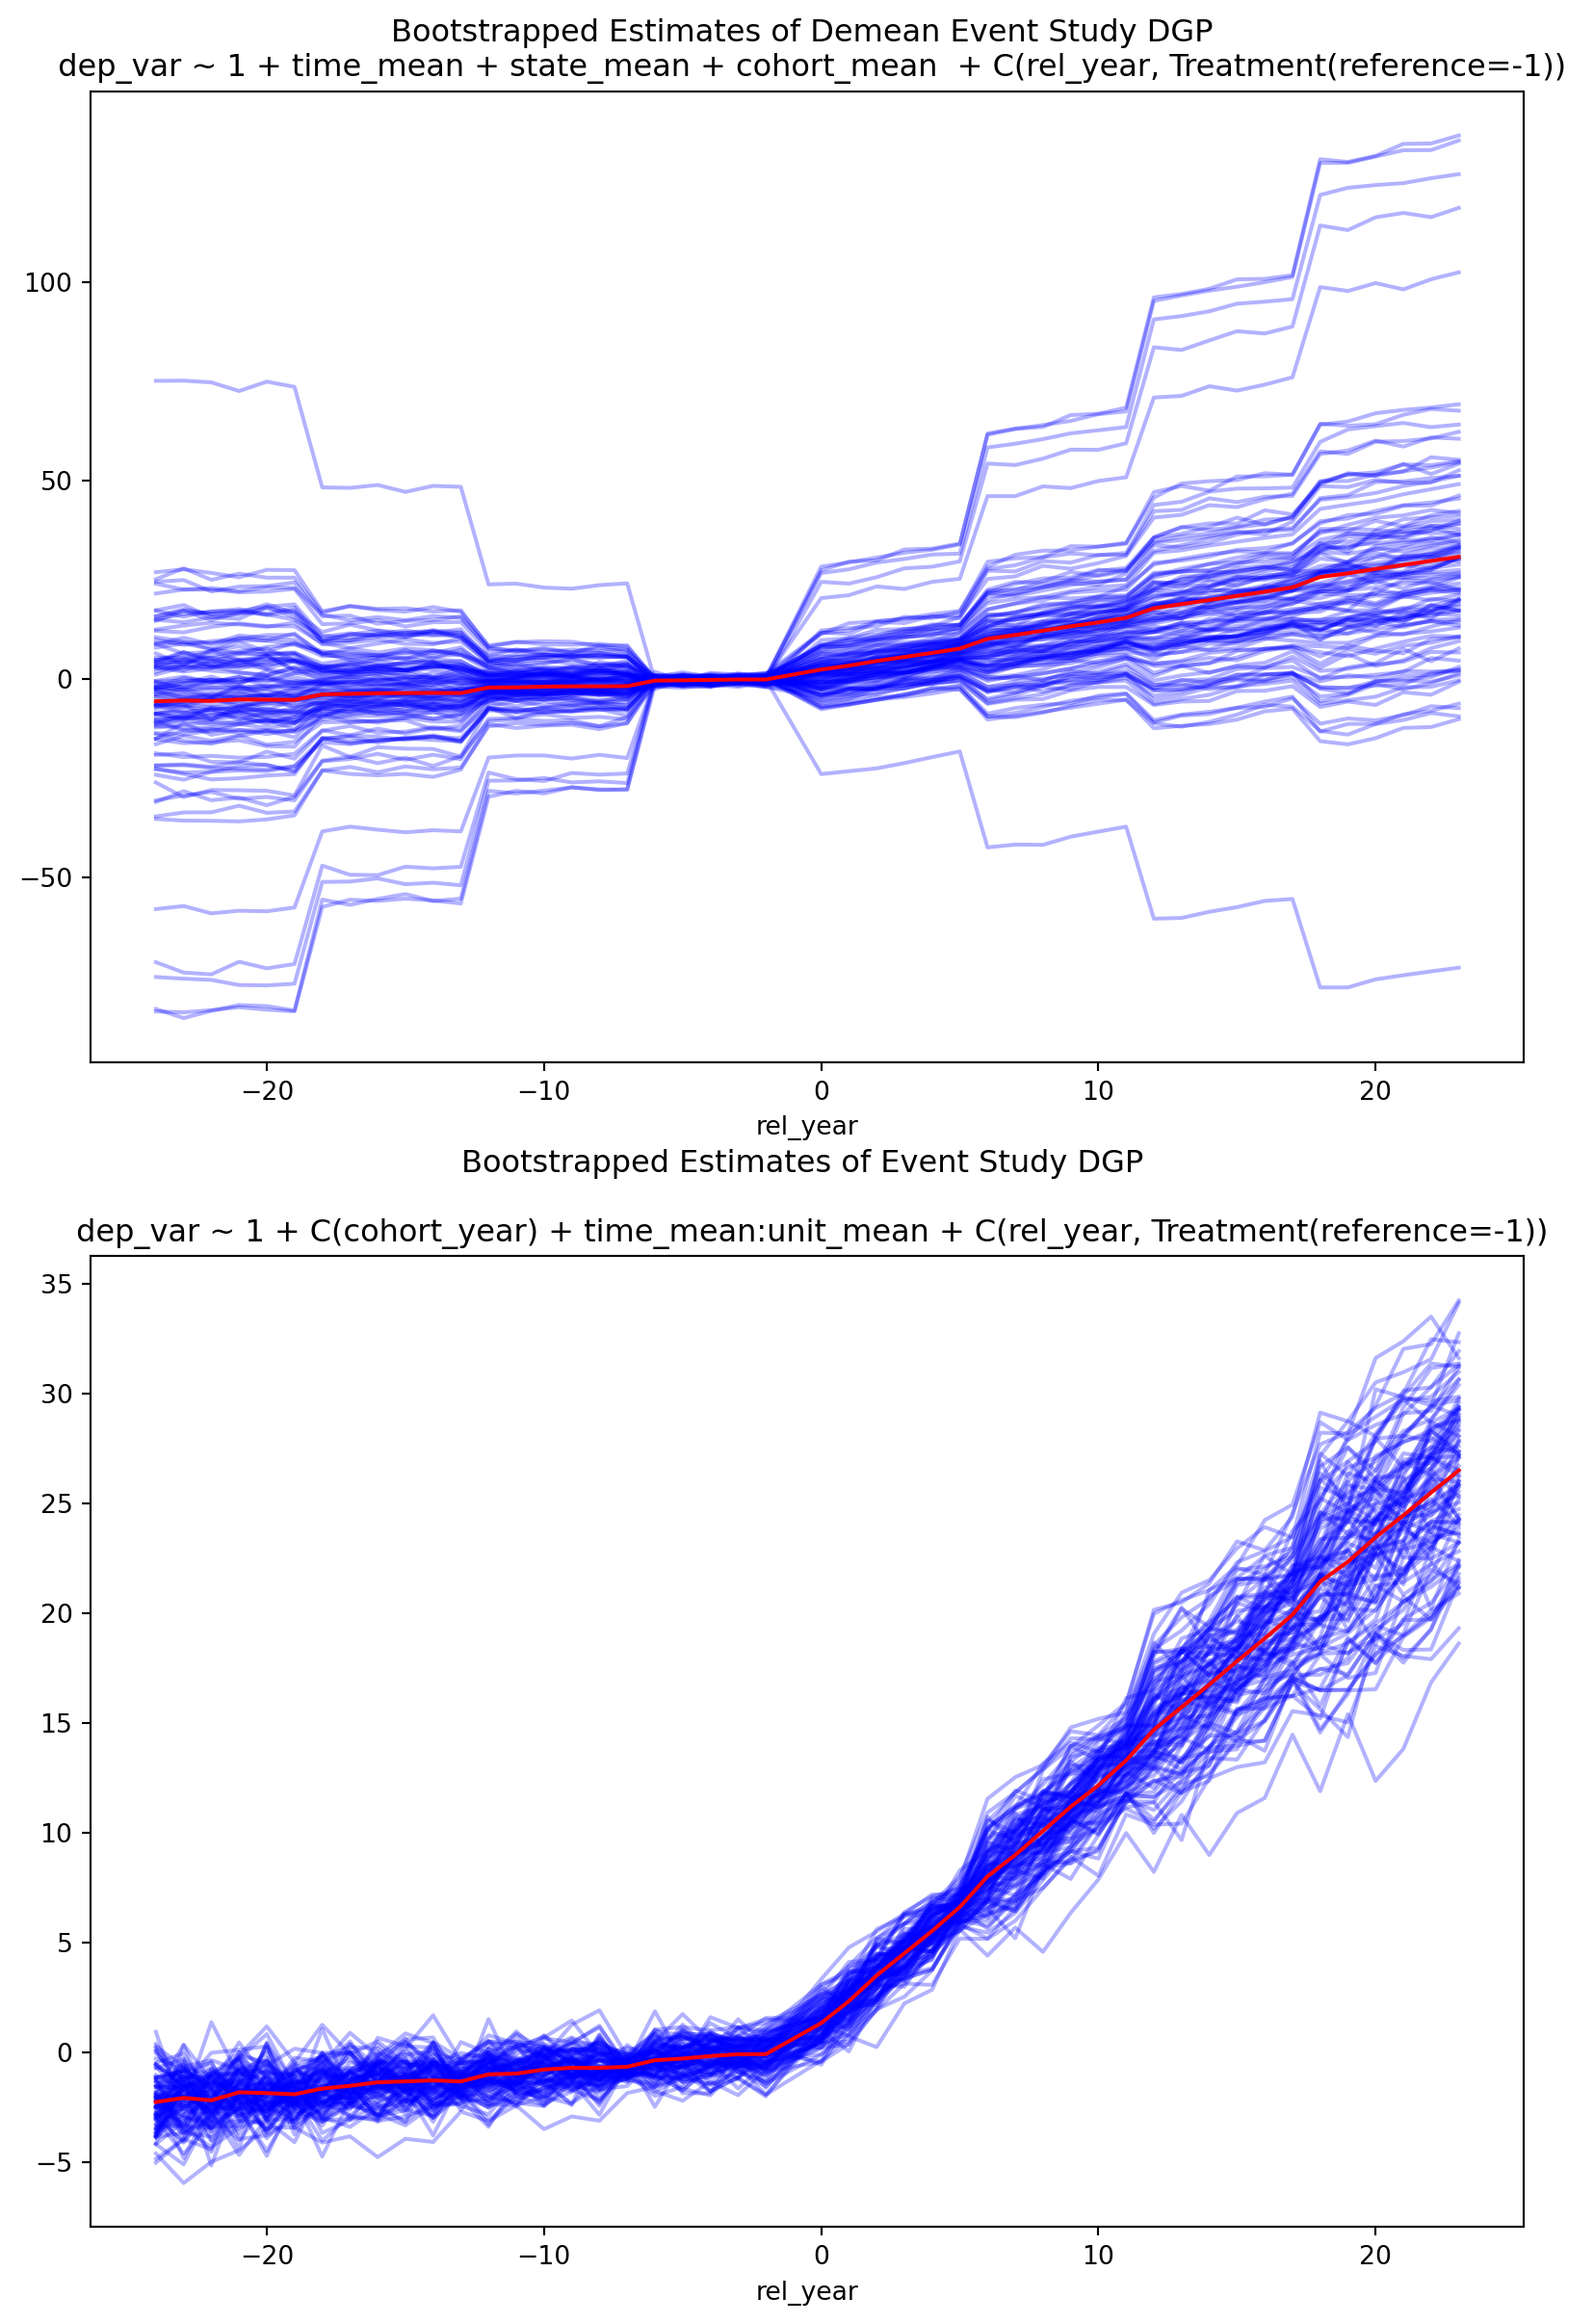

In [58]:
#| code-fold: true
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
axs = axs.flatten()
event_coefs = []
event_coefs1 = []

def fit_ols(formula, df_het):
    twfe_model_ols = smf.ols(formula, data=df_het).fit()
    twfe_model_ols.summary()
    param_est = pd.DataFrame(twfe_model_ols.params, columns=['estimate']).iloc[1:-1]
    param_est['index_number'] = list(range(len(param_est)))
    temp = (param_est.reset_index())
    param_est = temp[(~temp['index'].str.contains(':')) & (temp['index'].str.contains('rel'))]
    param_est.reset_index(inplace=True)
    try:
        param_est['rel_year'] =(param_est['index'].str.split('[', expand=True)[1].str.replace('T.', '')
        .str.replace(']', ''))
    except Exception as e:
        param_est['rel_year'] = param_est['level_0'] - 22
    param_est['rel_year'] = param_est['rel_year'].astype(int)
    param_est.set_index('rel_year', inplace=True)
    return param_est

for i in range(100):
    df_het = make_data(500, 40)
    df_het['state_mean'] = df_het.groupby('state')['treat'].transform(np.mean)
    df_het['time_mean'] = df_het.groupby('year')['treat'].transform(np.mean)
    df_het['cohort_mean'] = df_het.groupby('cohort_year')['treat'].transform(np.mean)
    df_het['unit_mean'] = df_het.groupby('unit')['treat'].transform(np.mean)

    formula = """ dep_var ~ 1 + time_mean + state_mean + cohort_mean  + C(rel_year, Treatment(reference=-1)) """
    formula1 = """ dep_var ~ 1 + C(cohort_year) + time_mean:unit_mean + C(rel_year, Treatment(reference=-1))"""

    param_est = fit_ols(formula, df_het)
    axs[0].plot(param_est['estimate'], color='blue', alpha=0.3)
    event_coefs.append(param_est['estimate'])
    param_est1 = fit_ols(formula1, df_het)
    axs[1].plot(param_est1['estimate'], color='blue', alpha=0.3)
    event_coefs1.append(param_est1['estimate'])

bootstrap_df = pd.DataFrame(event_coefs)
mean_df = bootstrap_df.mean(axis=0)
mean_df.index = param_est.index
mean_df.plot(ax=axs[0], color='red')
axs[0].set_title(f"""Bootstrapped Estimates of Demean Event Study DGP \n {formula}""")

bootstrap_df1 = pd.DataFrame(event_coefs1)
mean_df = bootstrap_df1.mean(axis=0)
mean_df.index = param_est1.index
mean_df.plot(ax=axs[1], color='red')
axs[1].set_title(f"""Bootstrapped Estimates of Event Study DGP \n
{formula1}""");

Here we see the importance of robustness tests in estimation techniques. In the above plot we see something like the correct pattern emerging in expectation, but absurd estimates occuring on individual cases. Whereas the bottom plot appears much more consistent across multiple draws from the data generating process. This points to something about the justification required for a credible result. Asymptotic accuracy is generally not sufficient for inducing credibility in any particular analysis of finite data.

We can also compare these models on standard adequacy measures. 


In [59]:
az.compare({'fe_mundlak_naive': idata_twfe, 
            'mundlak_state_time_interactions_cohort': idata_twfe1, 
            'mundlak_cohort_state_interactions': idata_twfe2, 
            'mundlak_state_hierarchical_year': idata_twfe3})

rank      elpd_loo      p_loo  \
mundlak_state_hierarchical_year            0 -35912.121738  71.861715   
mundlak_state_time_interactions_cohort     1 -36427.348488  53.252729   
mundlak_cohort_state_interactions          2 -38253.823151  46.733966   
fe_mundlak_naive                           3 -46324.604283  38.817673   

                                           elpd_diff    weight         se  \
mundlak_state_hierarchical_year             0.000000  0.814734  72.043100   
mundlak_state_time_interactions_cohort    515.226750  0.185265  74.447079   
mundlak_cohort_state_interactions        2341.701413  0.000007  78.036106   
fe_mundlak_naive                        10412.482545  0.000000  86.785658   

                                              dse  warning scale  
mundlak_state_hierarchical_year          0.000000    False   log  
mundlak_state_time_interactions_cohort  41.233117    False   log  
mundlak_cohort_state_interactions       49.586442    False   log  
fe_mundlak_naive                        97.436022    False   log

Again, we can plot the predictive performance of these models. Here we compare two via posterior predictive checks. Notable we see how the model with the better predictive performance also correctly estimates the treatement effects in the above plots. 

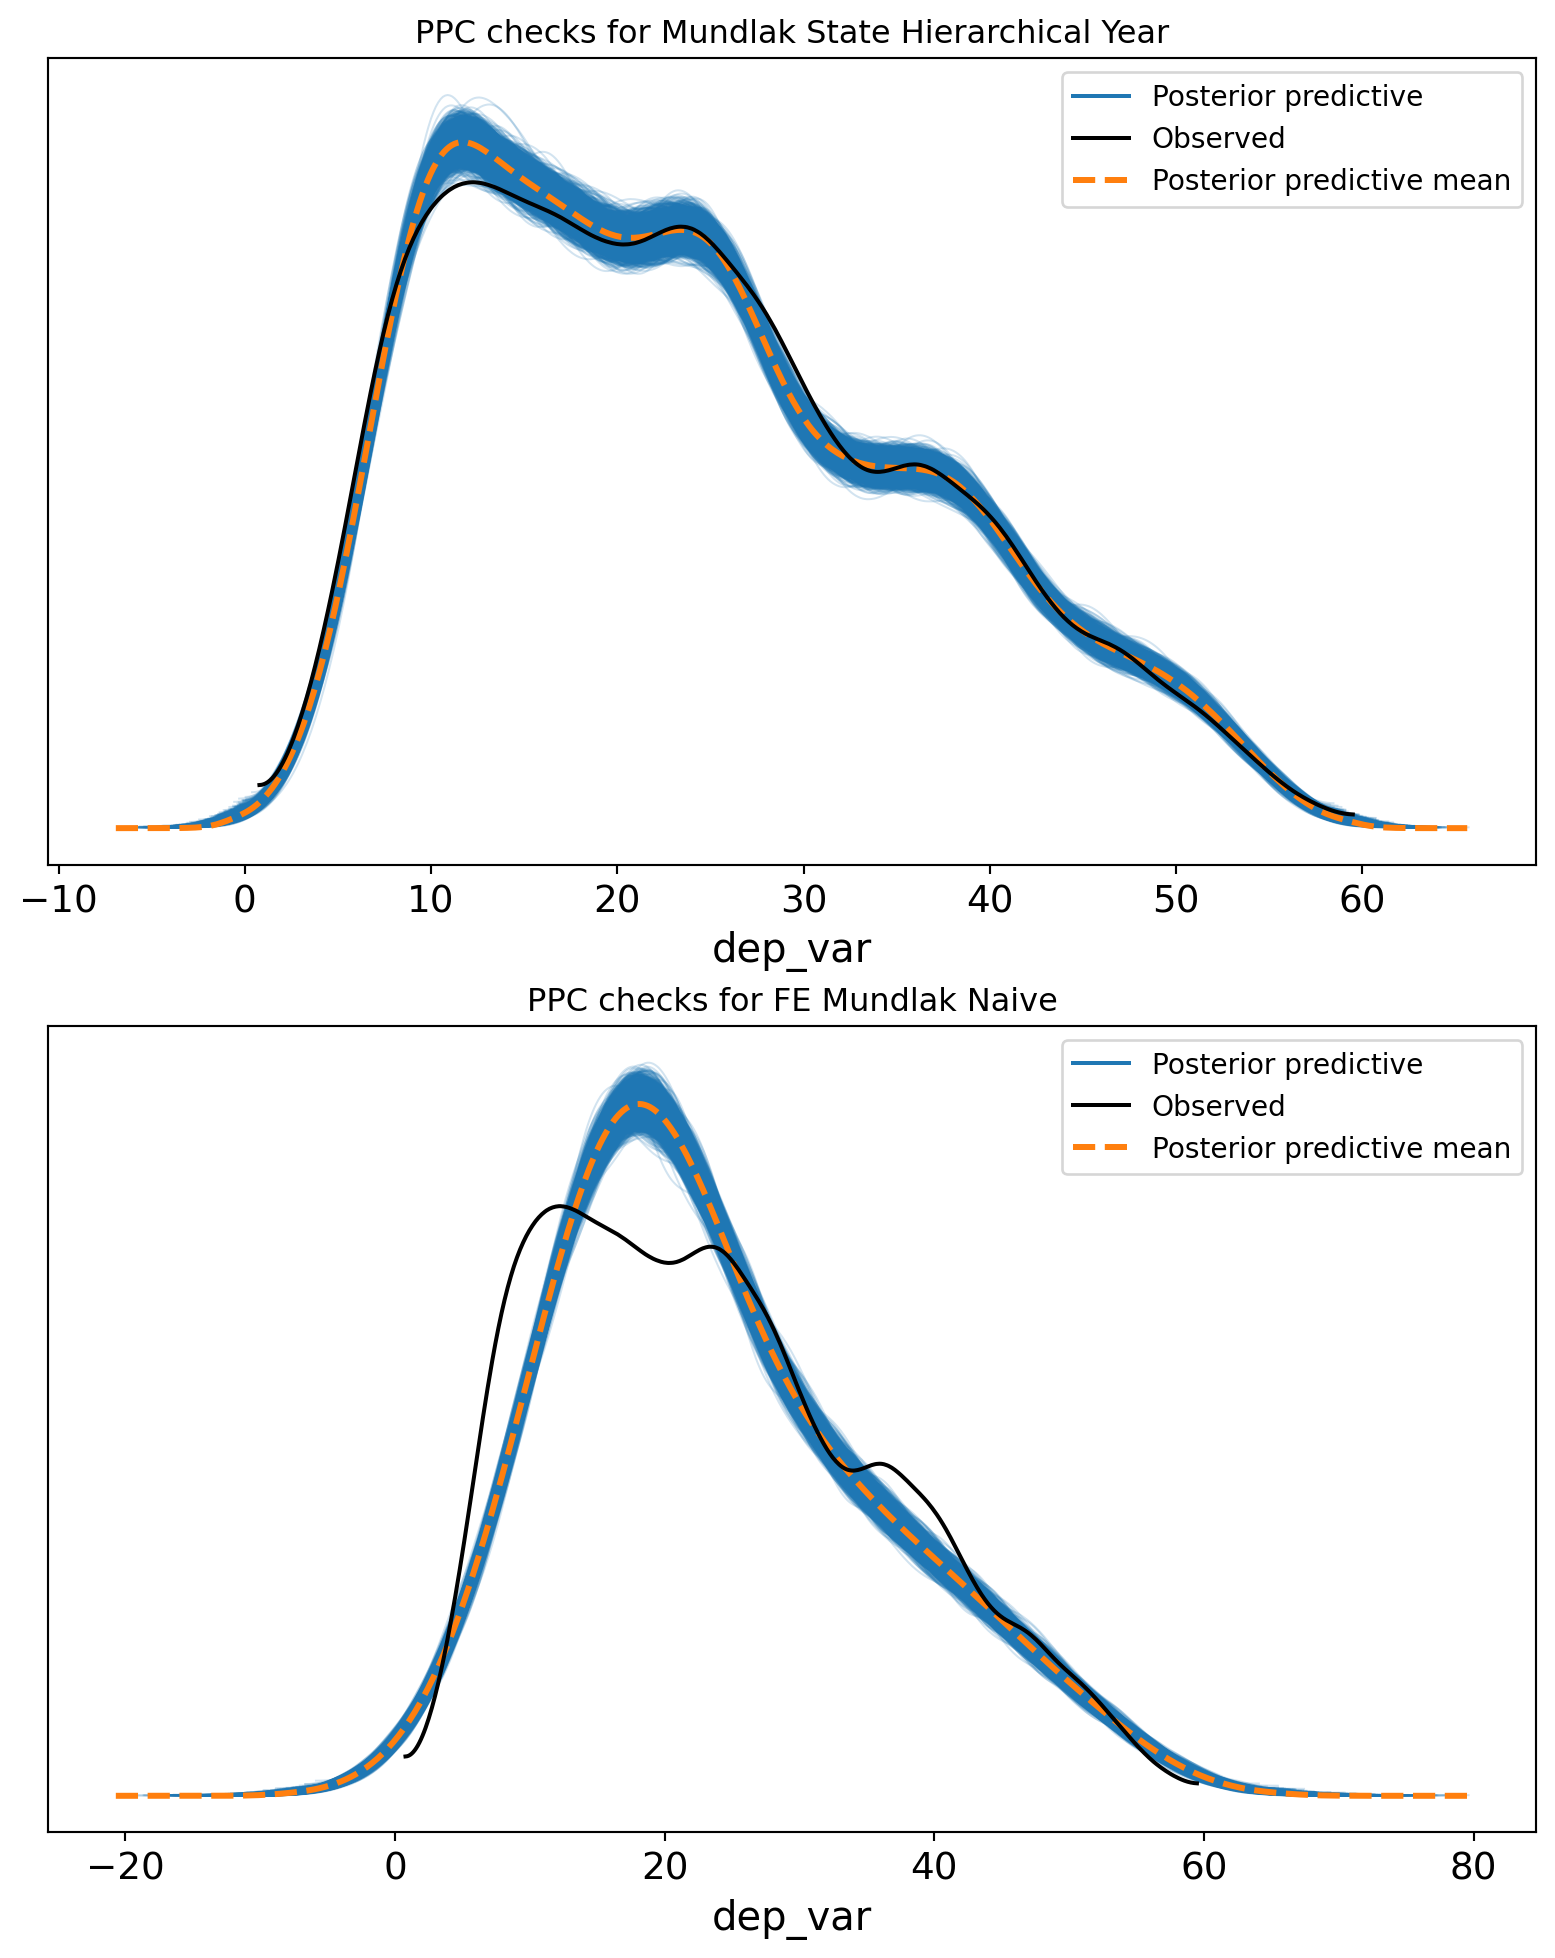

In [60]:
model_twfe3.predict(idata_twfe3, kind='pps')
model_twfe.predict(idata_twfe, kind='pps')
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs = axs.flatten()
az.plot_ppc(idata_twfe3, ax=axs[0])
axs[0].set_title("PPC checks for Mundlak State Hierarchical Year")
axs[1].set_title("PPC checks for FE Mundlak Naive")
az.plot_ppc(idata_twfe, ax=axs[1]);

It's certainly possible that parameter recovery accuracy and predictive performance come apart. But in lieu of knowledge of the true data generating processes, the route to credible models is via their calibration against real data. 

## Conclusion

> "A schema may be transported almost anywhere. The choice of territory for invasion is arbitrary; but the operation within that territory is almost never completely so." - Nelson Goodman in _Languages of Art_

We've now seen various cases of group-level confounding and strategies to address these issues. We've seen how they give rise to non-trivial questions about the effects of policy, and what can be learned in the face of group-level confounds. The case of TWFE's estimation is especially instructive - here we have an estimation technique applied well in limited circumstances, which ran into trouble when applied in contexts with a diverging data generating process. We all lose our way some of the time, but this misstep was due to a broken map - we'd followed the trail well past the intended territory. 

Statistical models do not mirror the world, they project patterns in the data. Each rupture between model and world is a gift that highlights deficits in our understanding - an impropriety of projections. It is therefore a delightful reversal to see, in Woolridge's proof, that the issue is not with the tooling but the thoughtless application of the tool. The unreasonable effectiveness of regression modelling is surely driven by projections of linearity on the world, but it remains compelling in approximation when used well. There are architectural constraints in causal inference - hard unyielding facts, that shape the contours of our design, and structure the steps we can make. The degree to which we can flexibly encode those structures in our models, the more compelling our models will be. It is this recognition of dual fit requirements between world and model - the focus on the conditions for identifiability - that lends causal inference any kind of credibility. The expressive capacity of generalised linear modelling enables us to articulate too many candidate pictures of the world. It's the business of science to cull those pictures, to find only the plausible representations of reality. 